In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import regex as reg
from mpl_toolkits.basemap import Basemap
from networkx.algorithms.community import greedy_modularity_communities
from matplotlib.colors import ListedColormap
%matplotlib inline

Loading the data about universities:

In [2]:
universities = pd.read_pickle('data/Universities.pkl')
universities.head()

file                               name        domain  \
0  import2018_371  University of Colorado at Boulder  colorado.edu   
1  import2018_371  University of Colorado at Boulder  colorado.edu   
2  import2018_371  University of Colorado at Boulder  colorado.edu   
3  import2018_417  Indiana University at Bloomington   indiana.edu   
4  import2018_417  Indiana University at Bloomington     gmail.com   

                             email  author_order        country        Lat  \
0     rebecca.swanson@colorado.edu             0  United States  40.006667   
1  leighanna.hinojosa@colorado.edu             1  United States  40.006667   
2       joseph.polman@colorado.edu             2  United States  40.006667   
3             huang220@indiana.edu             0  United States  39.167222   
4              agomoll90@gmail.com             1  United States  39.167222   

          Lon  
0 -105.267222  
1 -105.267222  
2 -105.267222  
3  -86.521389  
4  -86.521389

In [3]:
universities.rename(columns={'email': 'mail'}, inplace=True)

In [4]:
universities['merge_index'] = universities.apply(lambda x: x['file']+str(x['author_order']), axis=1)

metadata = pd.read_csv('data/Parsed_metadata.csv', index_col=0, parse_dates=['accessioned', 'available', 'issued'])
metadata.issued = metadata.issued.map(lambda x: x.year)
metadata['merge_index'] = metadata.apply(lambda x: x['file']+str(x['author_order']), axis=1)
associations = pd.merge(universities, metadata, on='merge_index')

In [5]:
associations.rename(columns={'file_x': 'file'}, inplace=True)

# Looking at co authorship, taking into consideration country and inst.

We use the associations frame again to build a co-authorship graph based on people with attributes country and institution

In [6]:
associations.columns
#we can drop one of the file columns
(associations.file != associations.file_y).sum()

0

In [7]:
del associations['file_y']

In [8]:
associations = associations[associations.country.notna()]

In [9]:
self_merge = pd.merge(associations, associations, on='file')
self_merge = self_merge[self_merge.long_name_x != self_merge.long_name_y]

#edges = self_merge[['long_name_x', 'long_name_y', 'issued_x']].copy()

nodes = associations[~associations.long_name.duplicated()].reset_index(drop=True).reset_index()
name_index = nodes.long_name.to_dict()
name_index = {v: k for k, v in name_index.items()}

In [10]:
self_merge['source'] = self_merge.long_name_x.map(name_index)
self_merge['target'] = self_merge.long_name_y.map(name_index)

In [11]:
def get_adjacency(nodes, edges):
    n_nodes = len(nodes)
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

    for idx, row in edges.iterrows():
        i, j = int(row.source), int(row.target)
        adjacency[i, j] += 1
        adjacency[j, i] = adjacency[i, j]


    return adjacency

In [12]:
adjacency = get_adjacency(nodes, self_merge)
graph = nx.from_numpy_array(adjacency)

Adding attributes to the graph:

In [13]:
edge_dict = {}
for i, row in self_merge.iterrows():
    edge_dict[(row['source'], row['target'])] =  row['issued_x']

In [14]:
nx.set_edge_attributes(graph, edge_dict, name='year')
nx.set_node_attributes(graph, nodes.country.to_dict(), name='country')
nx.set_node_attributes(graph, nodes.name.to_dict(), name='uni')
mapping = nodes.long_name.to_dict()
H=nx.relabel_nodes(graph,mapping)

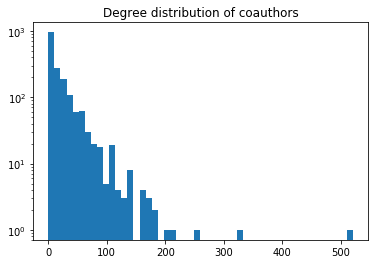

In [15]:
plt.title('Degree distribution of coauthors')
plt.hist(adjacency.sum(axis=1), bins=50, log=True)
plt.show()

This is a simple drawing of our network: we see that there is a large core communit, and many many smaller comminitues of co authors. We will look more into the main community

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


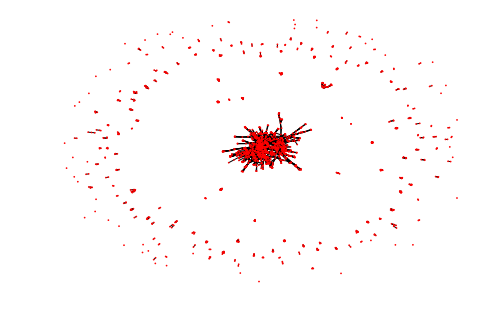

In [16]:
nx.draw(graph, pos=nx.spring_layout(graph), node_size=[0.5,0.5])

In [17]:
embedding = nodes.apply(lambda x: [x.Lon, x.Lat], axis=1)

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


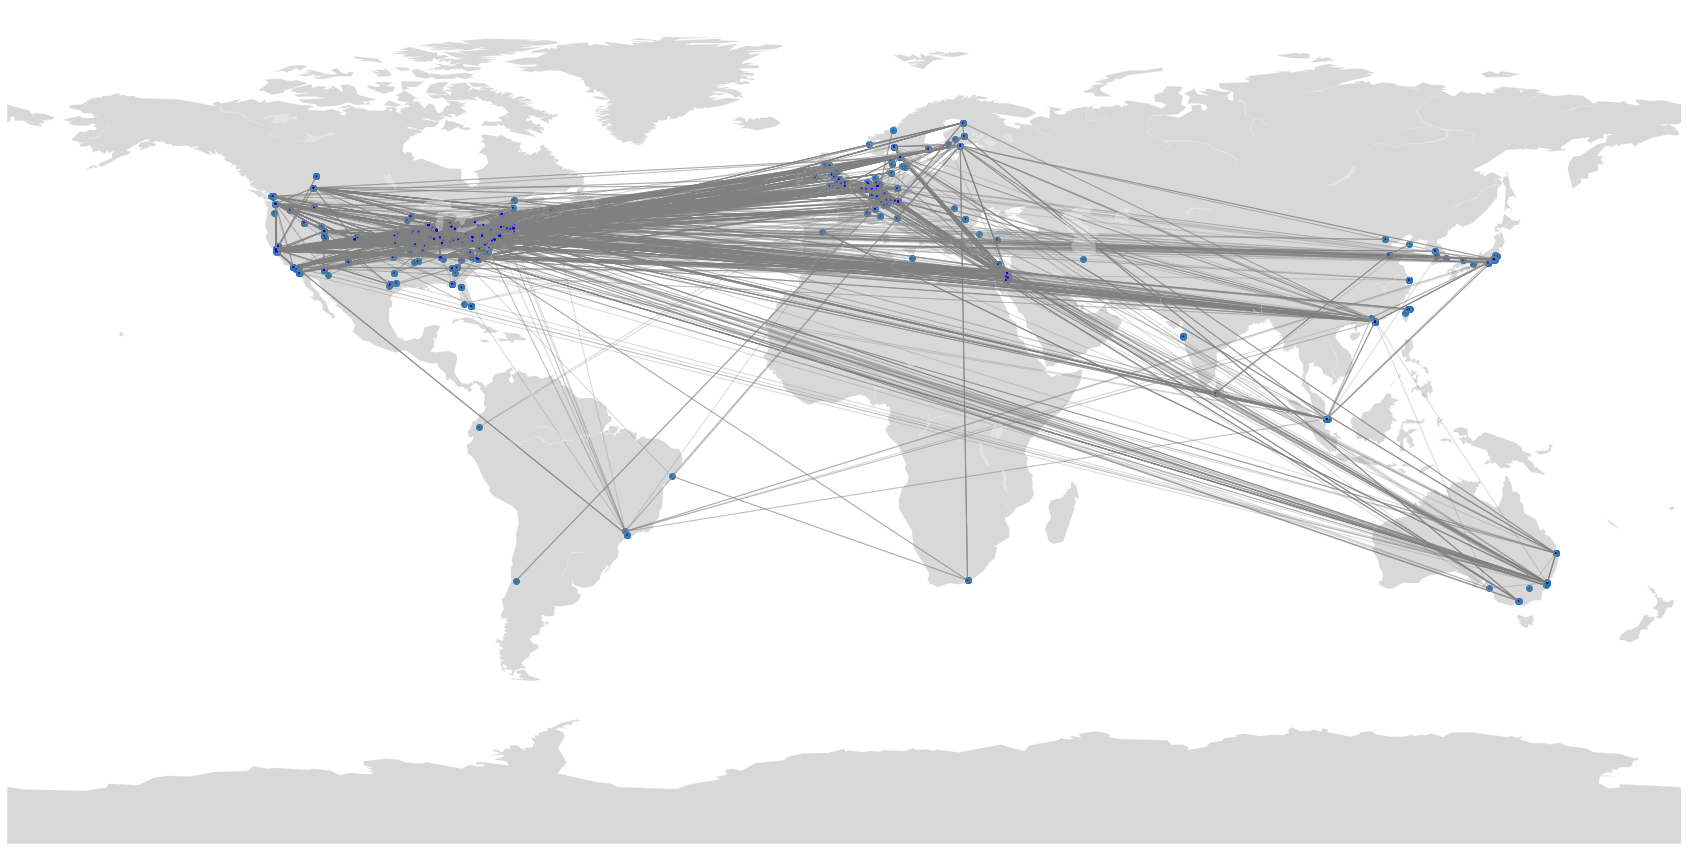

In [18]:
plt.figure(figsize=(30, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
data = nodes.copy()
 
# Add a point per position
m.scatter(data['Lon'], data['Lat'])
nx.draw(graph, node_size=[0.5,0.5], pos = embedding, edge_color='grey', node_color='b', alpha=0.3)

We focus in on the different components:

In [19]:
#get components
largest_cc = max(nx.connected_components(graph), key=len)

The total number of components is:

In [20]:
nx.number_connected_components(graph)

206

In [21]:
print(f'the largest component contains : {len(largest_cc)} people')

the largest component contains : 1136 people


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


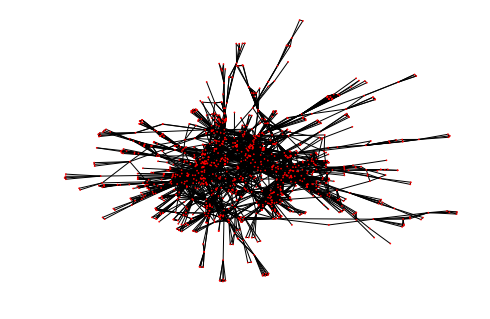

In [22]:
nx.draw(graph.subgraph(largest_cc), node_size=[0.5,0.5])

Drawing it in a geographical embedding:

In [23]:
def draw_map_plot(data, color='teal'):
    m=Basemap()
    m.drawmapboundary(linewidth=0)
    m.fillcontinents(color='grey', alpha=0.3)
    m.drawcoastlines(linewidth=0.1, color="white")
    m.scatter(data['Lon'], data['Lat'], s= 50, c= color, alpha=1)

In [24]:
embedding = nodes.iloc[list(largest_cc)].apply(lambda x: [x.Lon, x.Lat], axis=1)

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


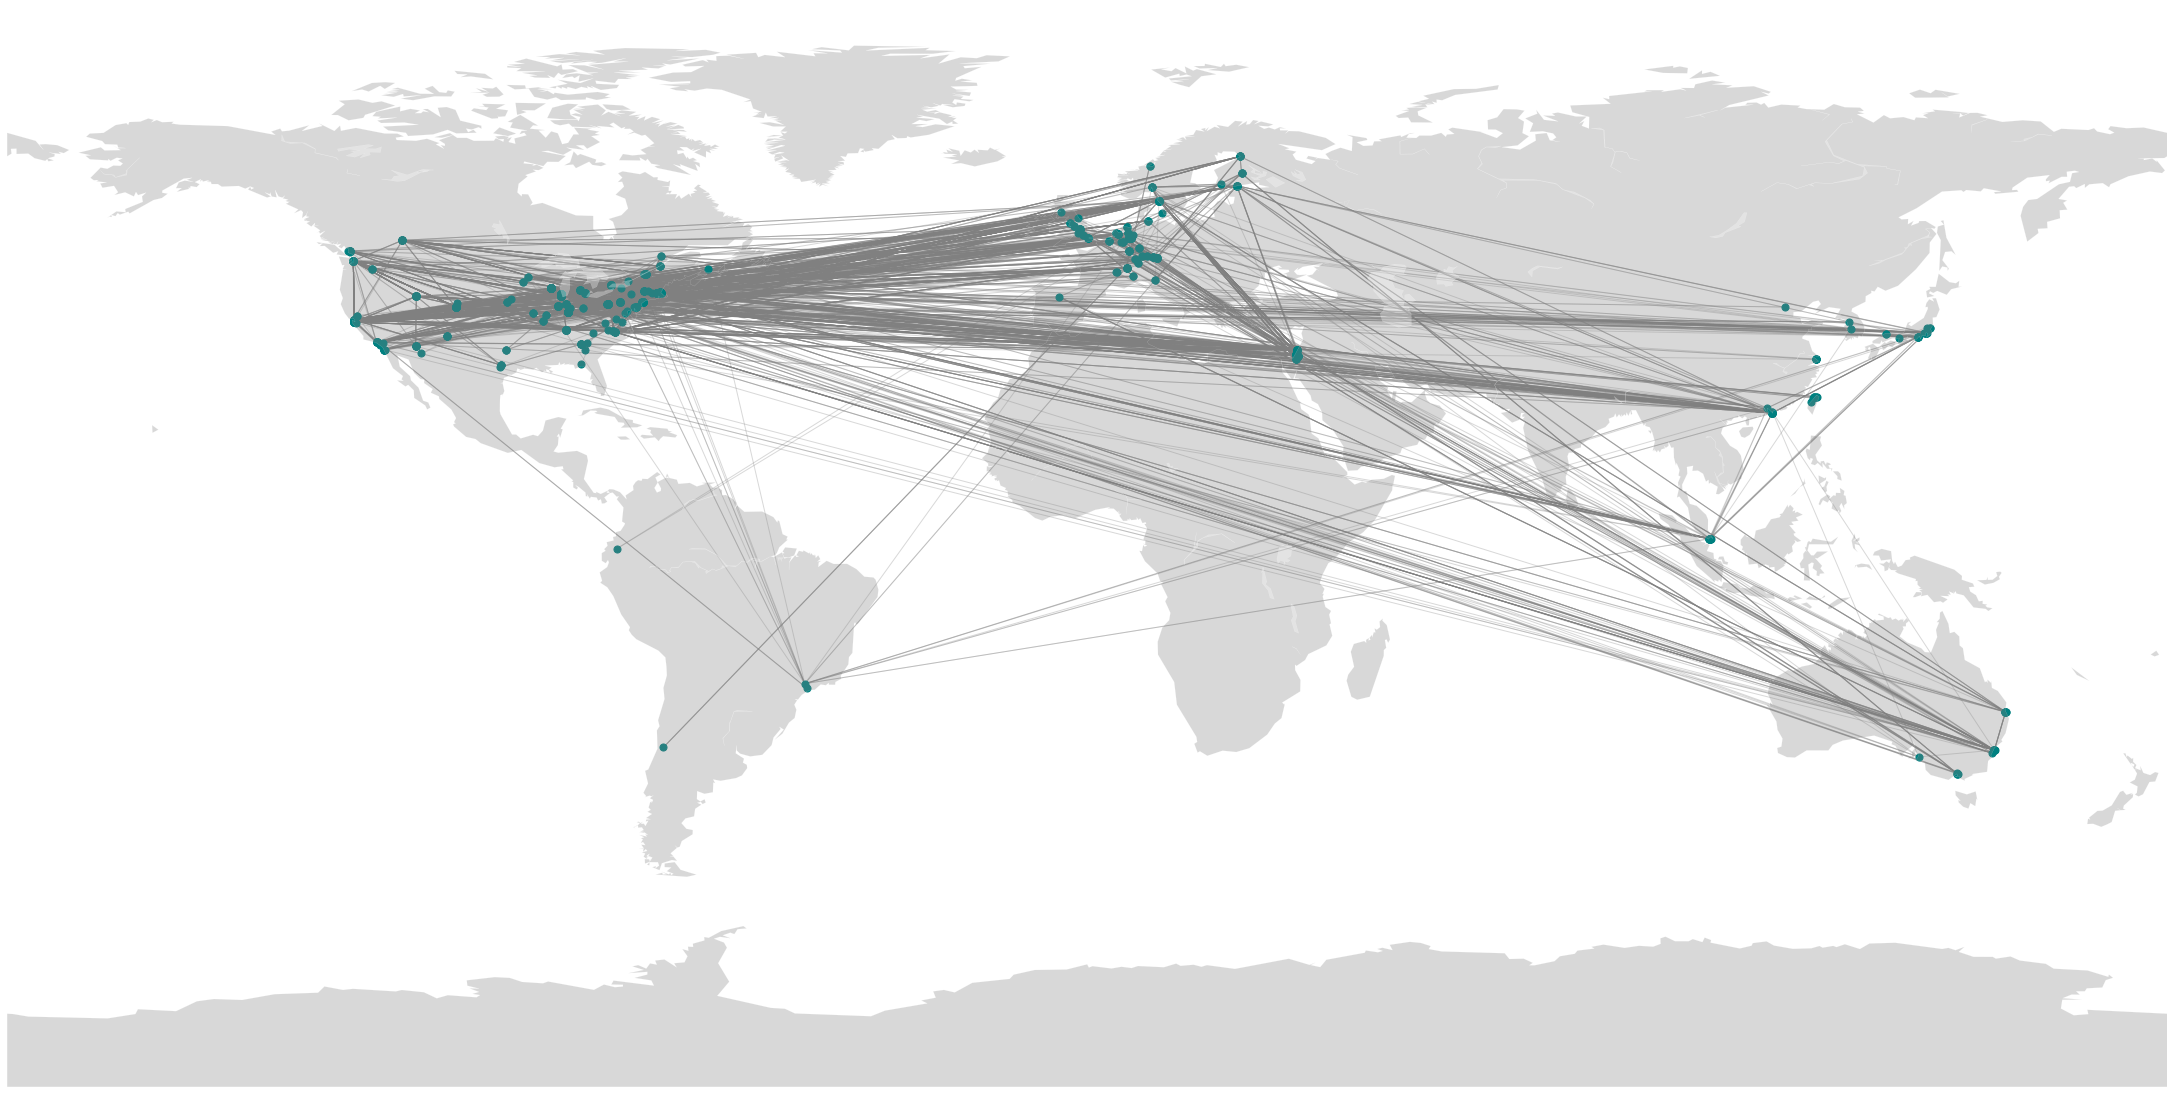

In [25]:
plt.figure(figsize=(30, 20))

 
# prepare a color for each point depending on the continent.
data = nodes.iloc[list(largest_cc)].copy()

#add edges
nx.draw(graph.subgraph(largest_cc), node_size=[0,0], pos = embedding, edge_color='grey', alpha=0.3)
draw_map_plot(data)

### Who colaborates the most:

We can easely find the people who worked with the most other people:
(counting repeat collaboration)

In [26]:
nodes['collabs_weighted'] = adjacency.sum(axis=1)
nodes.sort_values(by='collabs_weighted', ascending=False)[['long_name', 'country', 'name', 'collabs_weighted']].head(10)

long_name        country  \
179         Rummel, Nikol        Germany   
235          Linn, Marcia  United States   
63   Puntambekar, Sadhana  United States   
368         Gerard, Libby  United States   
154   Bielaczyc, Katerine  United States   
233      Vitale, Jonathan  United States   
38       Slotta, James D.         Canada   
388       Abrahamson, Dor  United States   
97         Zhang, Jianwei  United States   
120     Danish, Joshua A.  United States   

                                                  name  collabs_weighted  
179                             Ruhr-University Bochum               520  
235                 University of California, Berkeley               332  
63                   University of Wisconsin - Madison               252  
368                 University of California, Berkeley               208  
154  Hiatt Center for Urban Education, Clark Univer...               200  
233                 University of California, Berkeley               184  
38                               University of Toronto               182  
388                 University of California, Berkeley               172  
97              State University of New York at Albany               172  
120                  Indiana University at Bloomington               170

Same as above but counting person only once:

In [27]:
nodes['collabs_unweighted'] = np.where(adjacency > 0, 1, 0).sum(axis=1)
nodes.sort_values(by='collabs_unweighted', ascending=False)[['long_name', 'country', 'name', 'collabs_unweighted']].head(10)

long_name        country                                    name  \
146        Kali, Yael         Sweden                     Göteborg University   
38   Slotta, James D.         Canada                   University of Toronto   
179     Rummel, Nikol        Germany                  Ruhr-University Bochum   
97     Zhang, Jianwei  United States  State University of New York at Albany   
98      Chen, Mei-Hwa  United States  State University of New York at Albany   
39      Acosta, Alisa         Canada                   University of Toronto   
318     Rosé, Carolyn  United States              Carnegie Mellon University   
605       Bang, Megan  United States                University of Washington   
319     kafai, yasmin  United States              University of Pennsylvania   
460       Chan, Carol      Hong Kong                 University of Hong Kong   

     collabs_unweighted  
146                  63  
38                   61  
179                  61  
97                   59  
98                   54  
39                   54  
318                  53  
605                  51  
319                  50  
460                  49

### Zooming into largest community: - country & institution

In [28]:
main_component = nodes[nodes.index.isin(largest_cc)]

Comparing the country representation in main component to the one overall.

Text(0, 0.5, 'Counts')

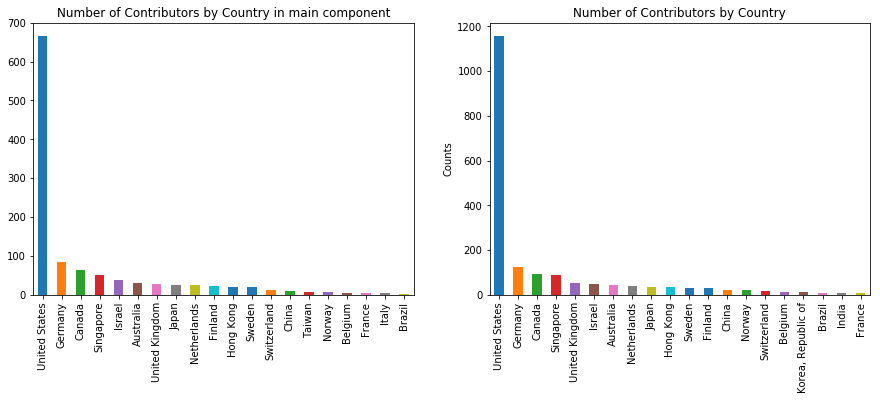

In [29]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Number of Contributors by Country in main component')
main_component.country.value_counts().head(20).plot(kind='bar')
plt.subplot(122)
universities[(~universities.mail.duplicated())].country.value_counts().head(20).plot(kind = 'bar')
plt.title('Number of Contributors by Country') # as determinded by university affiliation
plt.ylabel('Counts')

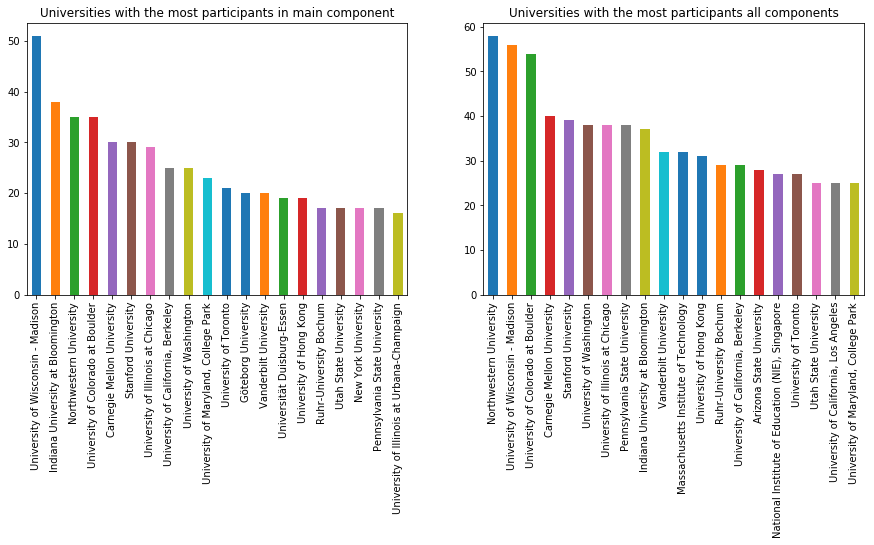

In [30]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
#plt.ylim([0, 60])
plt.title('Universities with the most participants in main component')
main_component.name.value_counts().head(20).plot(kind='bar')
plt.subplot(122)
#plt.ylim([0, 60])
plt.title('Universities with the most participants all components')
universities[(universities.name != 'gmail') & (~universities.mail.duplicated())].name.value_counts().head(20).plot(kind='bar')
plt.show()

## Finding communities in the community: Modularity and Other measures

Constructing the graph with the largest component:

In [31]:
main_component = graph.subgraph(largest_cc)
mapping = nodes.long_name.to_dict()
main_component=nx.relabel_nodes(main_component,mapping)

Here we use modularity to detect communities, which will find subgraph that are unliquely to have developed "randomly".

From wikipedia:

>It was designed to measure the strength of division of a network into modules (also called groups, clusters or communities). Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules. Modularity is often used in optimization methods for detecting community structure in networks

In [32]:
c = list(greedy_modularity_communities(main_component))

We find 18 communities in total:

In [33]:
len(c)

19

In [34]:
#smallest community:
min(c, key=len)

frozenset({'Quignard, Matthieu', 'Tchounikine, Pierre', 'Wang, Patrick'})

## Intermezzo: removing duplicate names!

We could use this to elliminate duplicates, merge some people:

The difficulty is to not have any false positives. False negatives are fine, We thus decide to look at similar names **within** the communities we found. Additionaly we check that the same last name is present and exclude some last names (chinese ones) as they are prone to lead to false positives.

In [35]:
#example of duplicates showing up!
metadata[metadata.long_name.isin(['Cuendet, Sebastien', 'Cuendet, Sébastien'])]

file                                            subject  \
1656    import2016full_68                                                NaN   
1742   import2015full_182  ['tangible user interface', 'eye-tracking', 'j...   
1862  import2015short_182  ['tangible user interface', 'eye-tracking', 'j...   

     iso                                       uri          type  \
1656  en             info:doi/10.22318/icls2016.68  Book chapter   
1742  en  https://doi.dx.org/10.22318/cscl2015.182  Book chapter   
1862  en  https://doi.dx.org/10.22318/cscl2015.182  Book chapter   

                                              publisher  \
1656  Singapore: International Society of the Learni...   
1742   International Society of the Learning Science...   
1862   International Society of the Learning Science...   

                                                  title  issued  \
1656  Detecting Collaborative Dynamics Using Mobile ...    2016   
1742  3D Tangibles Facilitate Joint Visual Attention...    2015   
1862  3D Tangibles Facilitate Joint Visual Attention...    2015   

             accessioned                                           citation  \
1656 2017-03-21 12:05:42  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   
1742 2017-06-19 14:15:51  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   
1862 2017-06-19 14:15:51  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   

               available                                           abstract  \
1656 2017-03-21 12:05:42  Prior work has successfully described how low ...   
1742 2017-06-19 14:15:51  We report results from a dual eye-tracking stu...   
1862 2017-06-19 14:15:51  We report results from a dual eye-tracking stu...   

                long_name  author_order shortend_names  \
1656   Cuendet, Sebastien             2      Sharma K.   
1742  Cuendet, Sébastien             2      Sharma K.   
1862  Cuendet, Sébastien             2      Sharma K.   

                                             identifier           merge_index  
1656  Schneider, B., Sharma, K., Cuendet, S., Zuffer...    import2016full_682  
1742  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   import2015full_1822  
1862  Schneider, B., Sharma, K., Cuendet, S., Zuffer...  import2015short_1822

Number of members before uniformisation:

In [36]:
import difflib
import unicodedata


def find_name_matching(c, threshold = 0.8, last_names_to_ignore = ['zhang', 'chen', 'liu', 'wang']):
    """finds different spellings of same name and gives mapping to create one person one name"""
    d = {}
    for community in c:
        members = list(community)
        for i, member in enumerate(members):
            for j, member_2 in enumerate(members):
                if i < j:
                    difference = difflib.SequenceMatcher(None, member, member_2).ratio()
                    if difference > threshold:
                        last_1 =reg.search('[\p{L}]*', unicodedata.normalize('NFC', member.lower())).group(0)
                        last_2 = reg.search('[\p{L}]*', unicodedata.normalize('NFC', member_2.lower())).group(0)
                        same_last_name = reg.search('[\p{L}]*', 
                                                    member.lower()).group(0) == reg.search(
                            '[\p{L}]*', member_2.lower()).group(0)
                        if same_last_name and last_1 not in last_names_to_ignore  and not member_2 in d.keys():
                            d[member_2] = member
    return d

d = find_name_matching(c)
len(d)

19

In [37]:
d

{'Azevedo, Flávio S.': 'Azevedo, Flavio S.',
 'Chan, Carol K.K.': 'Chan, Carol',
 'Cuendet, Sebastien': 'Cuendet, Sébastien',
 "D'Angelo, Sarah": 'D’Angelo, Sarah',
 'Davis, Richard': 'Davis, Richard Lee',
 'Dornfeld, Catherine': 'Dornfeld, Catherine L.',
 'Eagan, Brendan': 'Eagan, Brendan R.',
 'Greenhow, Chrisine': 'Greenhow, Christine',
 'Keifert, Danielle Teodora': 'Keifert, Danielle',
 'Lee, Victor R.': 'Lee, Victor',
 'Levy, Sharona T': 'Levy, Sharona T.',
 'Madhok, Jacquie': 'Madhok, Jacqueline',
 'Penuel, William': 'Penuel, Bill',
 'Quintana, Rebecca M': 'Quintana, Rebecca',
 'Schunn, Chris': 'Schunn, Christian',
 'Severance, Sam': 'Severance, Samuel',
 'Shareff, Becca': 'Shareff, Rebecca',
 'Sheldon, Josh': 'Sheldon, Joshua',
 'Wu, Sally P. W.': 'Wu, Sally P.W.'}

Reason why we normalize the string:

In [38]:
ord(u'ä')

228

In [39]:
for c in u"ä":
    print(repr(c), ord(c))

'a' 97
'̈' 776


Now creating the graph as before with the better naming:

In [40]:
improved_associations = associations.copy()

improved_associations.loc[improved_associations.long_name.map(d).notna(), 'long_name'] = improved_associations.long_name.map(d)

self_merge = pd.merge(improved_associations, improved_associations, on='file')
self_merge = self_merge[self_merge.long_name_x != self_merge.long_name_y]
nodes = improved_associations[~improved_associations.long_name.duplicated()].reset_index(drop=True).reset_index()

name_index = nodes.long_name.to_dict()
name_index = {v: k for k, v in name_index.items()}

self_merge['source'] = self_merge.long_name_x.map(name_index)
self_merge['target'] = self_merge.long_name_y.map(name_index)

new_graph = nx.from_numpy_array(get_adjacency(nodes, self_merge))

components = nx.connected_components(new_graph)
largest_cc = max(nx.connected_components(new_graph), key=len)

main_component = new_graph.subgraph(largest_cc)
mapping = nodes.long_name.to_dict()

## clique detection:


Here we look at large groups of researchers that all have collaborated within eachother.
Only look at connections with weight at least 3 -> at least 3 collaborations, froming a clique of at least 7 people.

In [41]:
mc = nx.from_numpy_array(np.where(nx.to_numpy_array(main_component) >= 3, 1, 0))

main_component_ =nx.relabel_nodes(mc, mapping)
large_cliques = [l for l in list(nx.find_cliques(main_component_)) if len(l) > 6]

large_cliques[0]

['Chelule, Geoffrey',
 'Hall, Allison H',
 'Weintrop, David',
 'Killen, Heather',
 'Woods, Dawn',
 'Martin, Nicole D.',
 'Warren, Beth',
 'Philip, Thomas M.',
 'Liu, Kun',
 'Tofel-Grehl, Colby']

We get a total of 12 groups:

In [42]:
len(large_cliques)

13

In [43]:
main_component_clique = nx.from_numpy_array(nx.to_numpy_array(main_component))

In [44]:
mc = nx.from_numpy_array(np.where(nx.to_numpy_array(main_component_clique) >=3, 1, 0))

In [45]:
large_cliques = [l for l in list(nx.find_cliques(mc)) if len(l) > 6]
color_cliques = {}
set_inclique = set()
for i, clique in enumerate(large_cliques):
    for member in clique:
        color_cliques[member] = i+1
        set_inclique.add(member)

In [46]:
for member in (set(main_component_clique.nodes)-set_inclique):
    color_cliques[member] = 0

Define colormap for better plotting:

   0  ||  1  ||  2  ||  3  ||  4  ||  5  ||  6  ||  7  ||  8  ||  9  ||  10  ||  11  ||  12


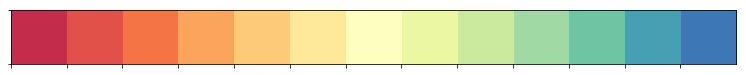

In [47]:
palette = sns.color_palette(palette='Spectral', n_colors=len(large_cliques))

sns.palplot(palette)
print('  ', '  ||  '.join([str(i) for i in list(range(len(large_cliques)))]))

In [48]:
colors = ['#C7C7C7'] + \
    sns.color_palette(palette='Spectral', n_colors=30).as_hex()

In [49]:
node_size = (np.array(list(nx.degree_centrality(main_component_clique).values())))
edge_color= np.array(list(nx.get_edge_attributes(main_component_clique, 'weight').values()))

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


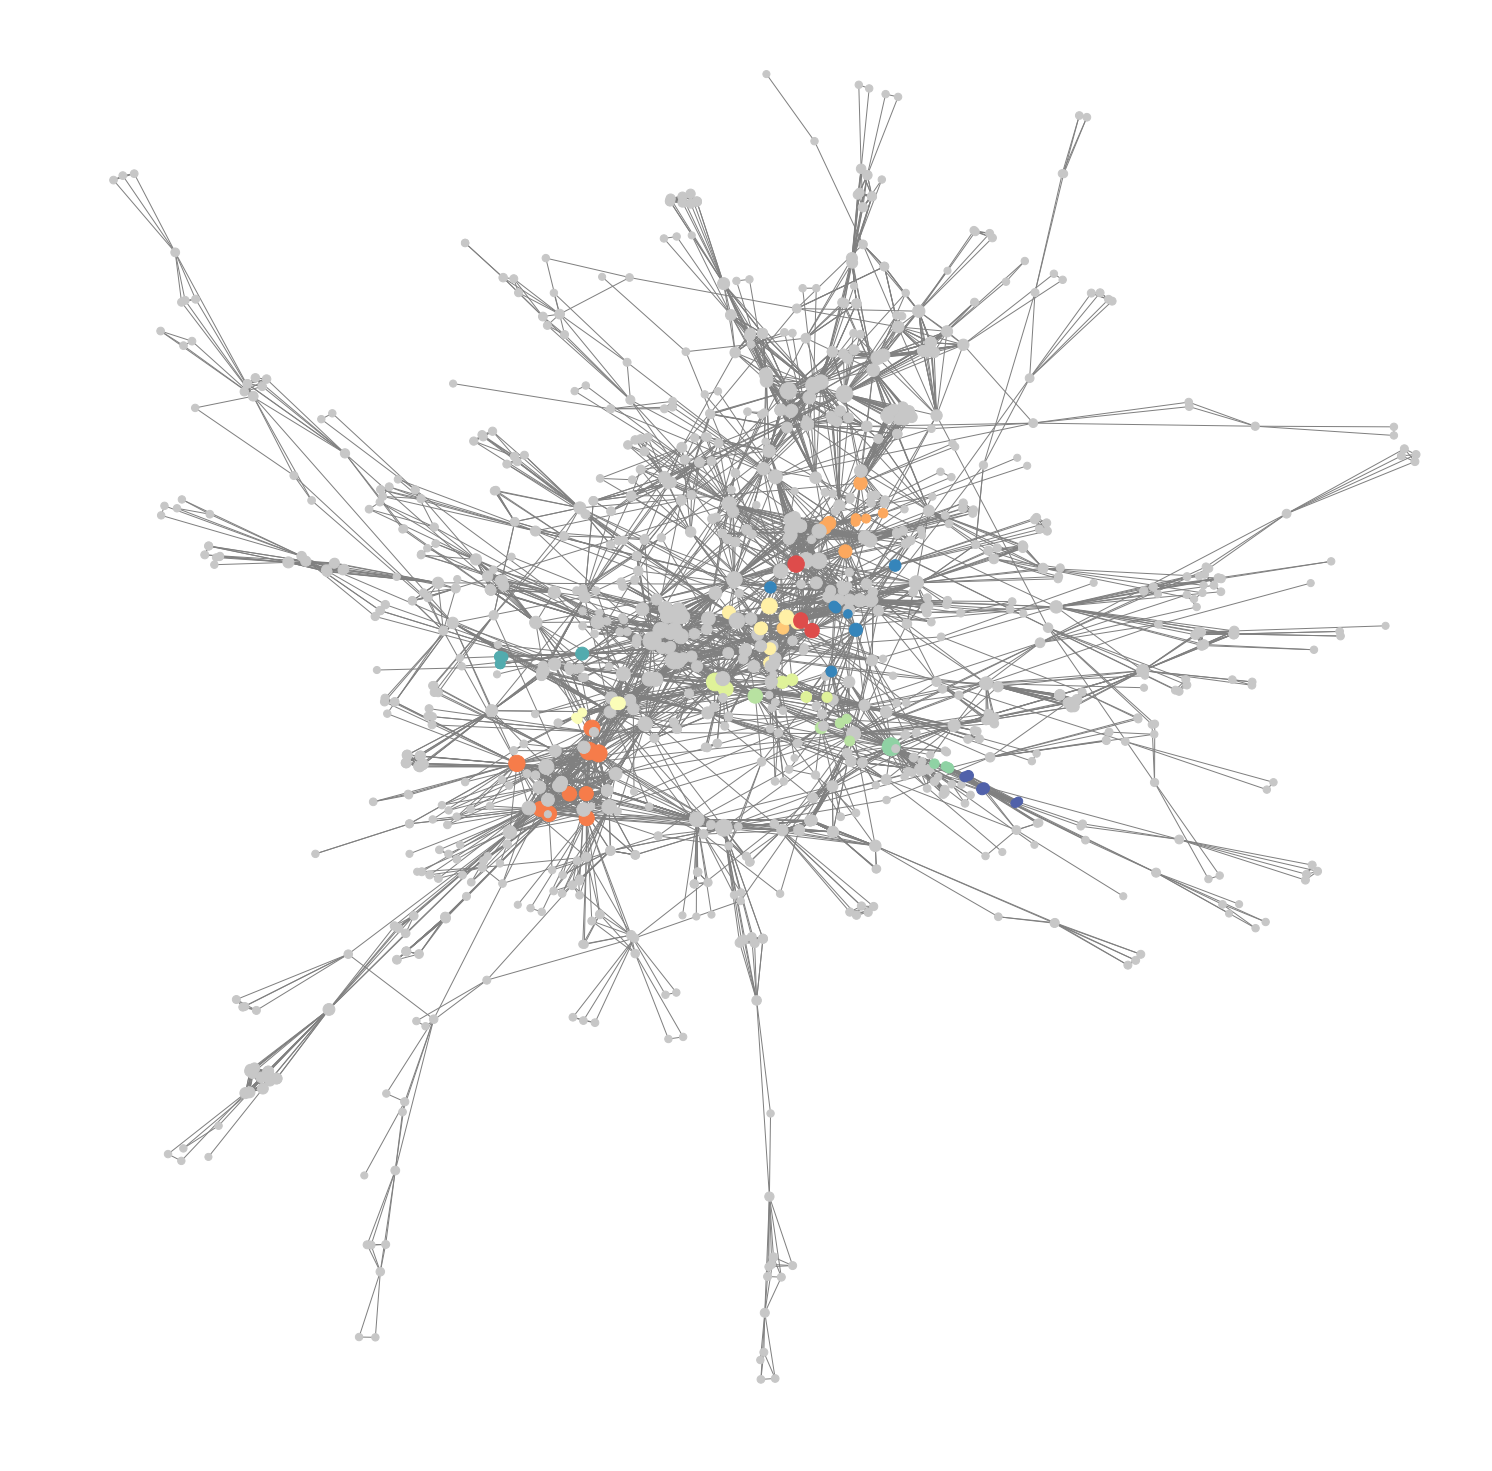

In [50]:
plt.figure(figsize=(20, 20))
nx.draw_spring(main_component_clique, node_color=pd.Series(color_cliques).sort_index().tolist(), 
              cmap=ListedColormap(colors),
              node_size=(node_size+node_size.mean())*5000,
               edge_color='grey',
               iterations=400)

In [51]:
color = {}
for i, clique in enumerate(large_cliques):
    for member in clique:
        color[member] = i+2

Here we look at these large cliques on a map. We see that while there are global comunities, many are bound to north america. Additonaly, such large collaboration networks do not exist on other continents! 

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


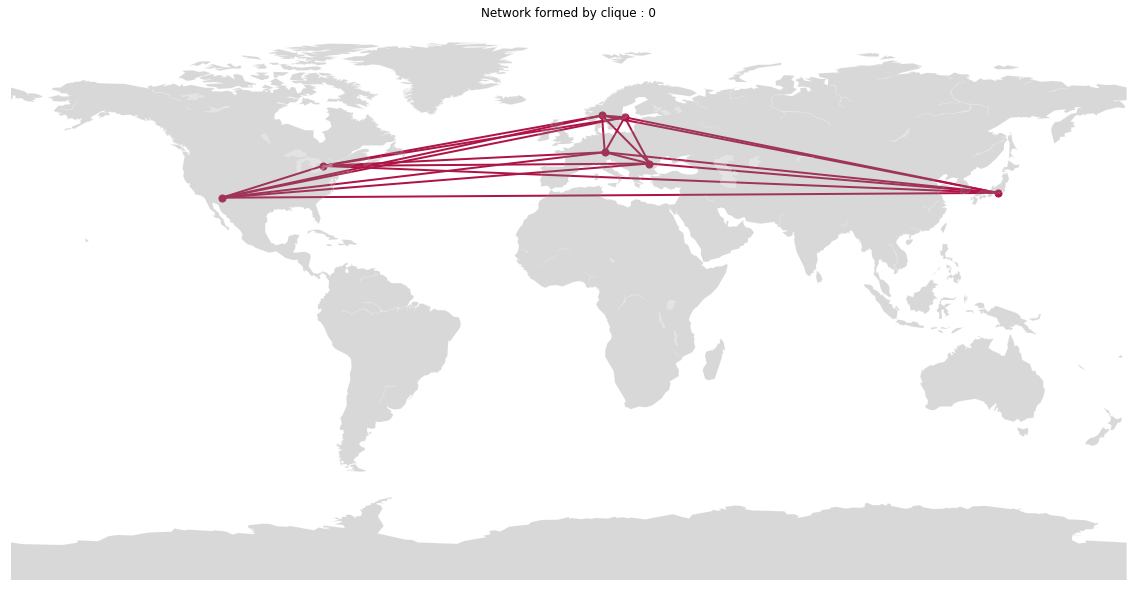

['Rodriguez, James', 'Berg, Yngvar', 'Oshima, Ritsuko', 'Wen, Yun', 'Collin, Jonas', 'Dascalu, Mihai', 'Tarnai, Christian', 'Håklev, Stian']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


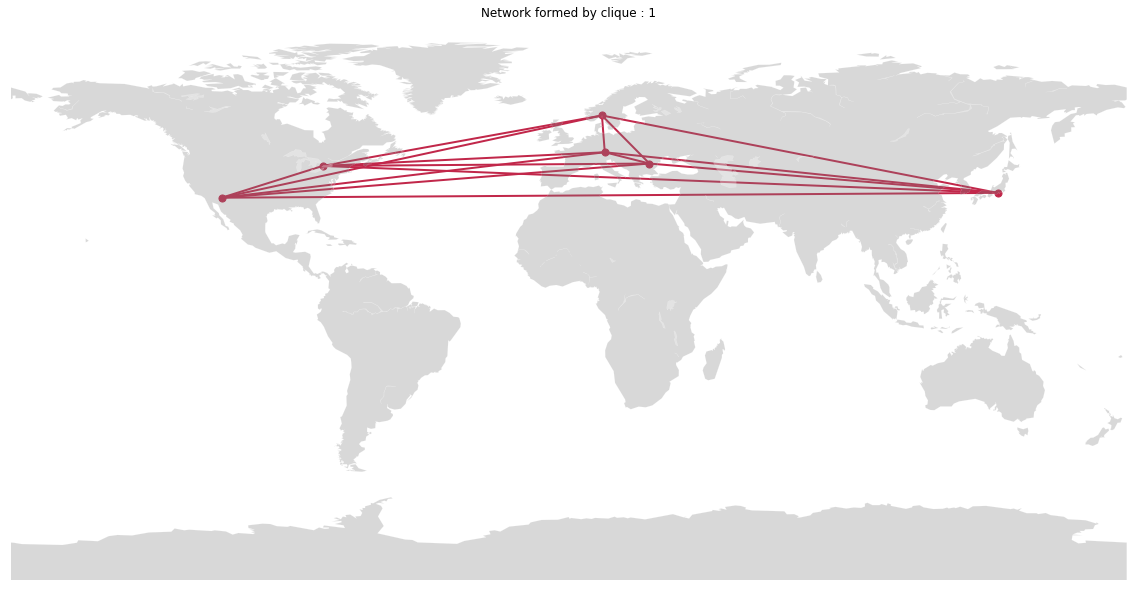

['Rodriguez, James', 'Berg, Yngvar', 'Oshima, Ritsuko', 'Bonsignore, Elizabeth', 'Dascalu, Mihai', 'Tarnai, Christian', 'Håklev, Stian']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


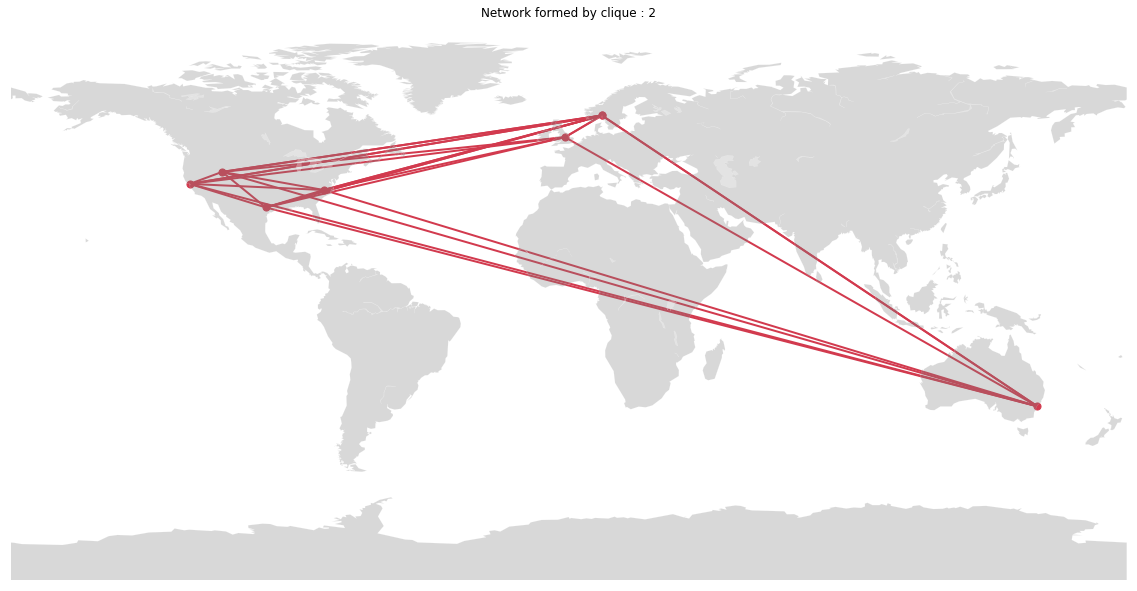

['Shapiro, R. Benjamin', 'Kluge, Anders', 'Wigmore, Peter', 'Dolonen, Jan Arild', 'Mann, Michele J.', 'Lobczowski, Nikki G.', 'Dorph, Rena', 'Feraud, Iván Silva', 'Braden, Sarah']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


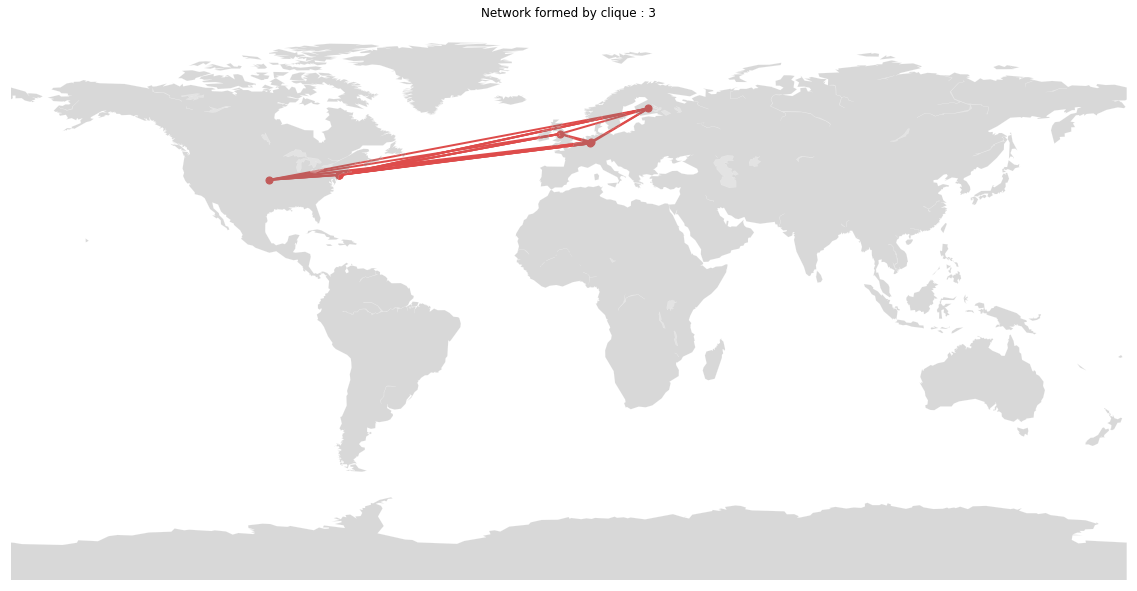

['Genz, Florian', 'Sayre, Eleanor C', 'kang, Seokbin', 'Flake, Sabrina', 'Slater, Stefan', 'Xing, Chenmu', 'Sarmiento, Juan Pablo', 'Öztok, Murat', 'Arvaja, Maarit']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


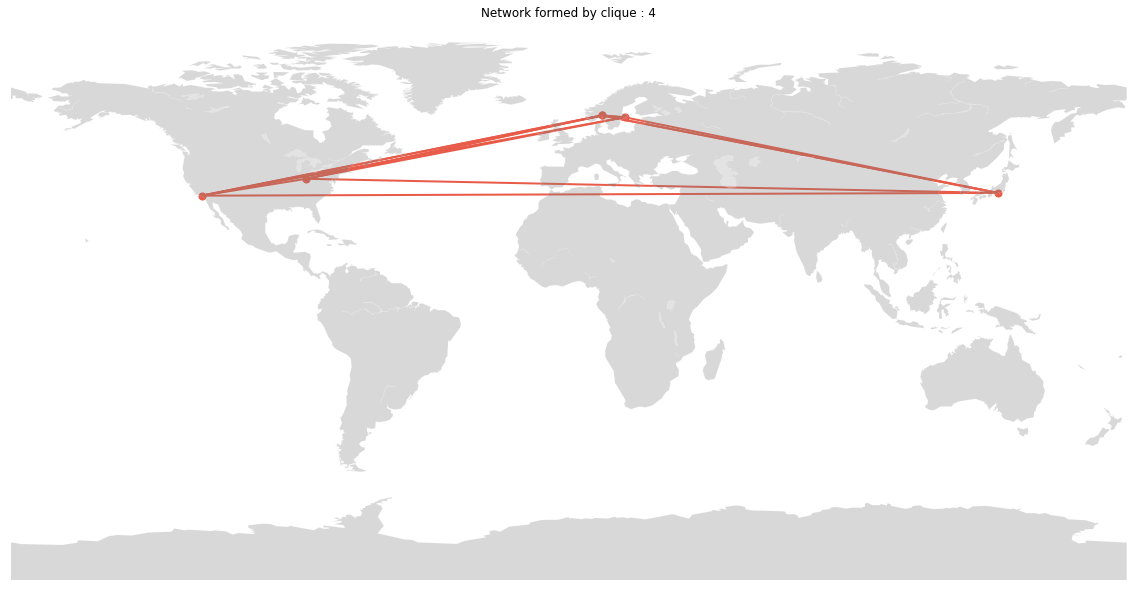

['Oshima, Ritsuko', 'Berg, Yngvar', 'Wen, Yun', 'Collin, Jonas', 'Pham, Josephine', 'Davis, Darrel', 'Damsa, Crina']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


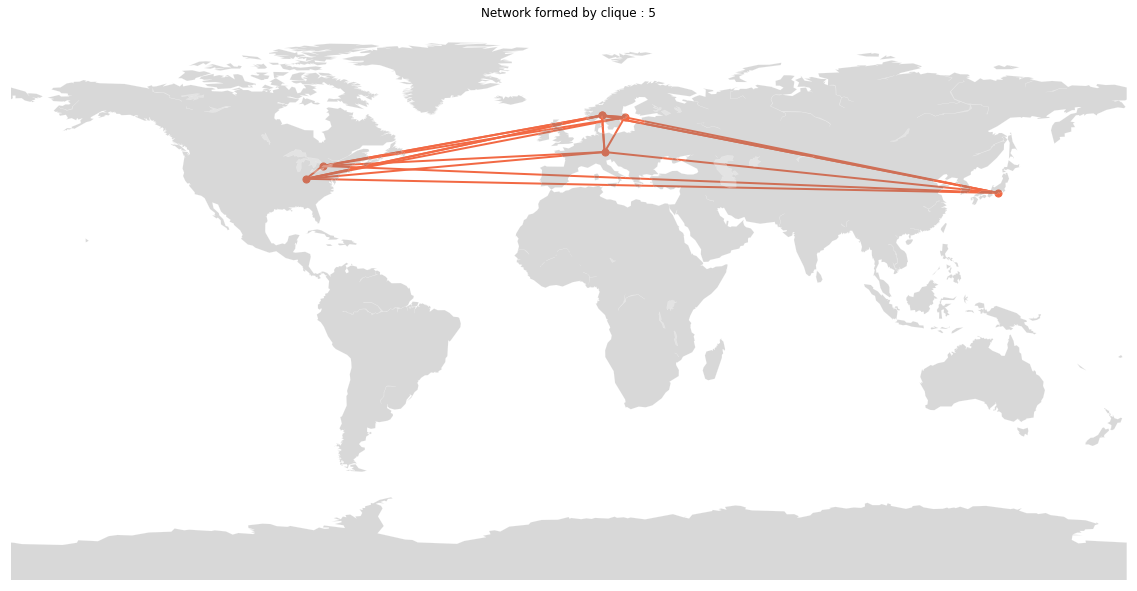

['Oshima, Ritsuko', 'Berg, Yngvar', 'Wen, Yun', 'Collin, Jonas', 'Håklev, Stian', 'Davis, Darrel', 'Nistor, Nicolae', 'Damsa, Crina']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


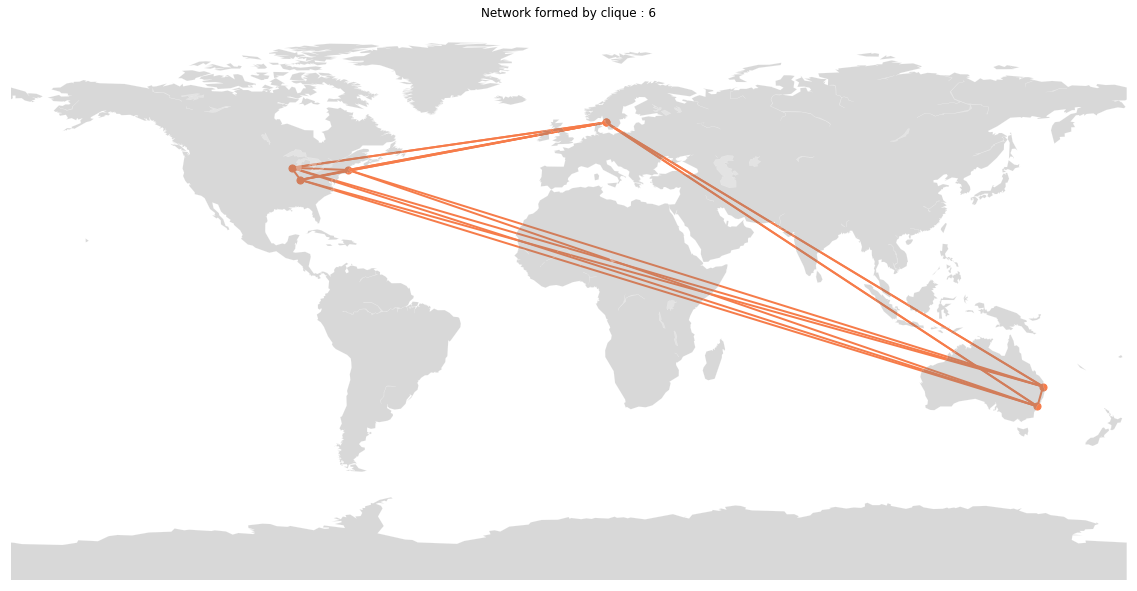

['Patel, Purav', 'Anderson, Emma', 'Danish, Joshua A.', 'Anderson, Theresa Dirndorfer', 'Hillman, Thomas', 'Renshaw, Peter', 'Solli, Anne']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


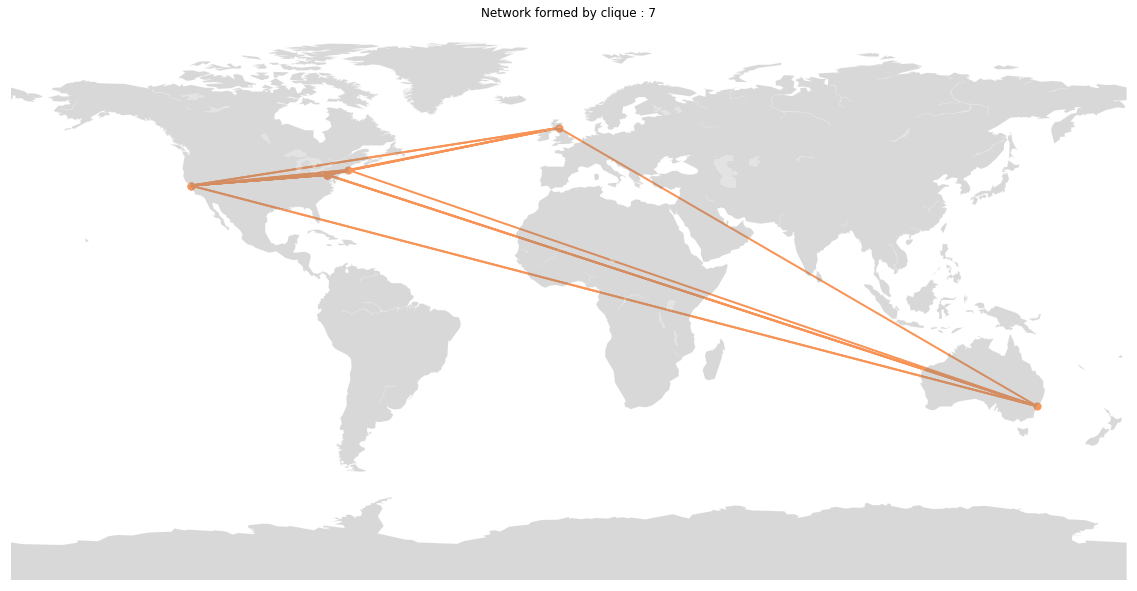

['McDonald, Scott', 'Curwood, Jen Scott', 'Dragomir, Mihaela', 'Walsh, Elizabeth M.', 'Cordero, Eugene', 'Blum-Smith, Sarah', 'Toprani, Dhvani', 'Borge, Marcela', 'Xia, Yu']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


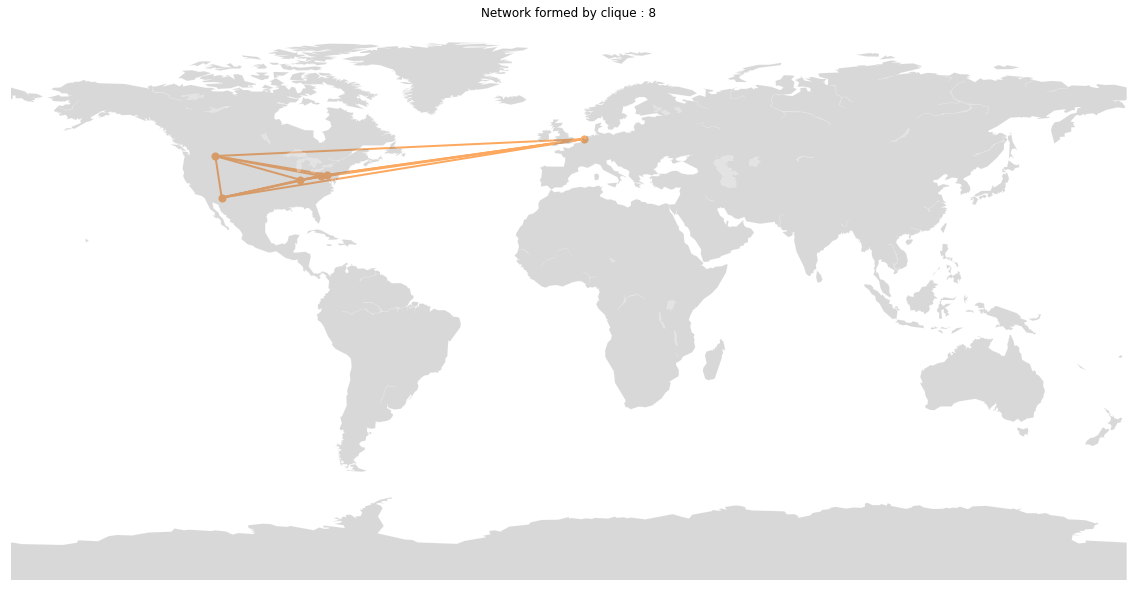

['McDonald, Scott', 'Adams, Joshua Adams', 'Plane, Angelisa C.', 'Sun, Jingjing', 'Cook, Lucas', 'Molenaar, Inge', 'Campen, Carolien Knoop-van']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


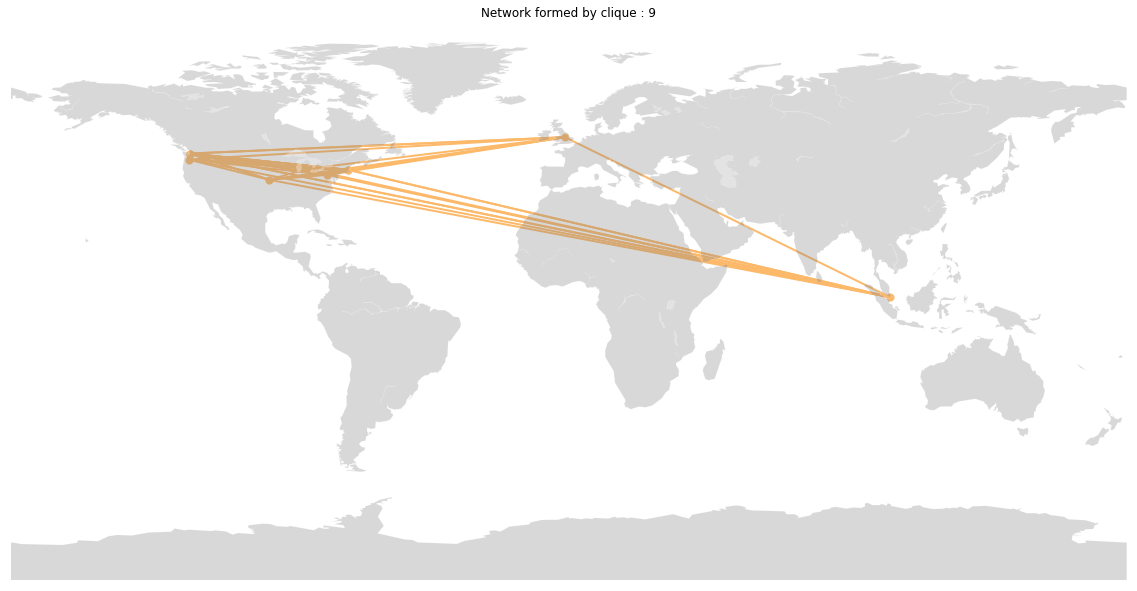

['McDonald, Scott', 'Ke, Li', 'Wagh, Aditi', 'Tierney, Gavin', 'Horstman, Theresa', 'Rodela, Katherine', 'Archibeque, Benjamin Archibeque', 'Chu, Shien', 'Jaafar, Nurjanah Mohd', 'Gouvea, Julia Svoboda']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


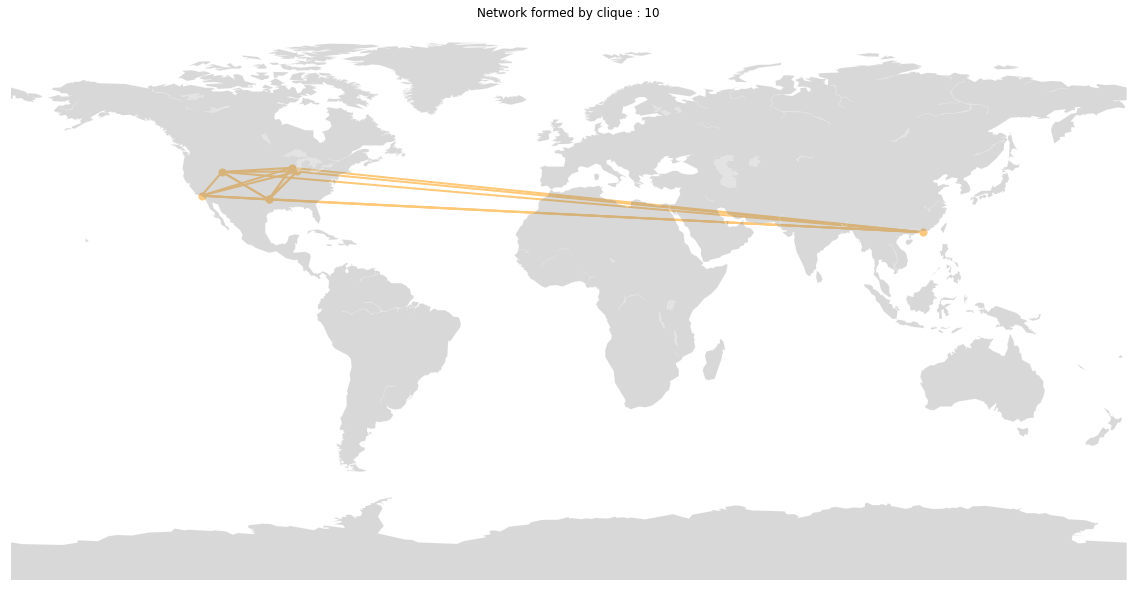

['Martin, Nicole D.', 'Warren, Beth', 'Philip, Thomas M.', 'Weintrop, David', 'Killen, Heather', 'Hall, Allison H', 'Liu, Kun', 'Chelule, Geoffrey', 'Woods, Dawn', 'Tofel-Grehl, Colby']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


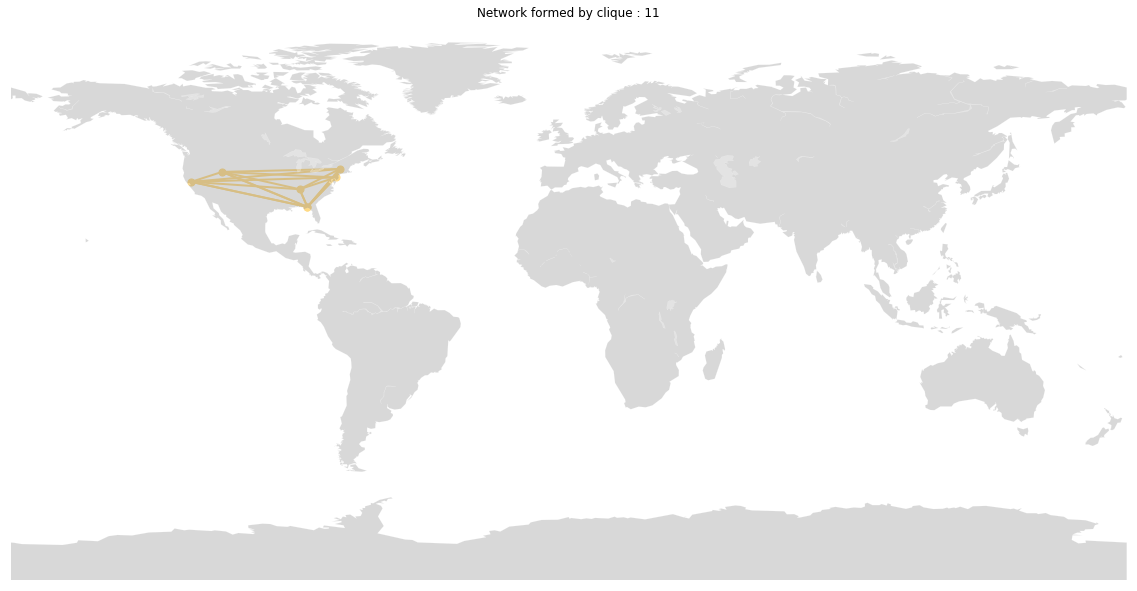

['Ching, Cynthia Carter', 'Chen, Mei-Hwa', 'Gresalfi, Melissa', 'Karumbaiah, Shamya', 'Rahimi, Seyedahmad', 'Baker, Ryan', 'Shute, Valerie']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


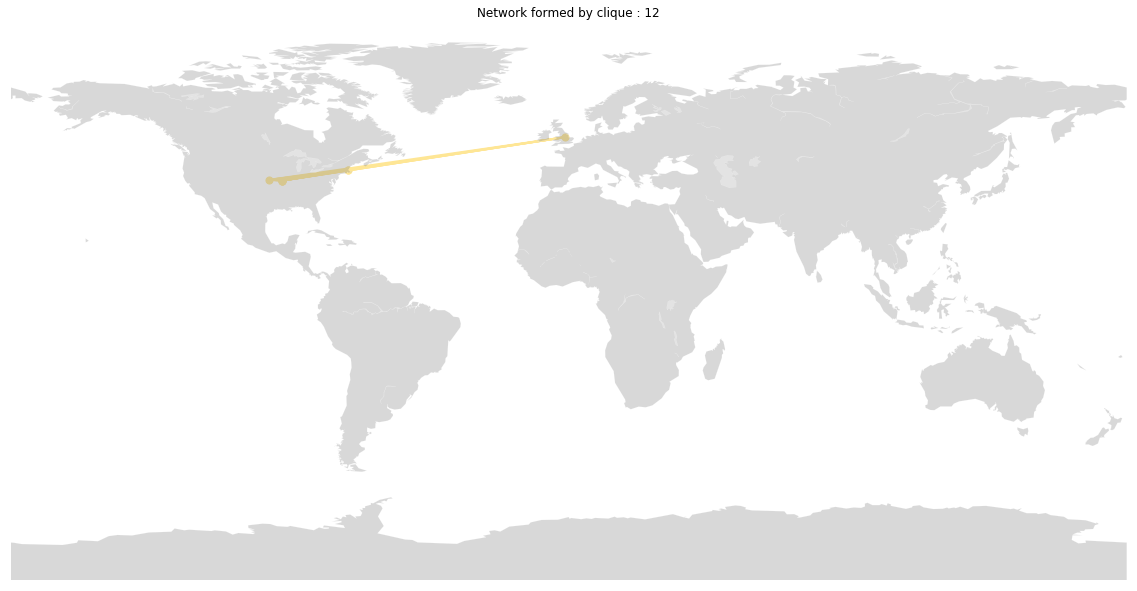

['Munter, Charles', 'Wagh, Aditi', 'Bruton, Rebecca', 'Archibeque, Benjamin Archibeque', 'Haines, Cara', 'Jaafar, Nurjanah Mohd', 'Gouvea, Julia Svoboda']


In [52]:
# prepare a color for each point depending on the continent.
 
# Add a point per position
for i, clique in enumerate(large_cliques):

    plt.figure(figsize=(20, 20))

    data = nodes.iloc[list(clique)].copy()
    draw_map_plot(data, colors[i+1])

    embedding = data.apply(lambda x: [x.Lon, x.Lat], axis=1)
    
    nx.draw_networkx_edges(main_component_clique.subgraph(clique),  pos = embedding, 
                           edge_color=colors[i+1], width = 2)
    plt.title('Network formed by clique : {}'.format(i))
    plt.show()
    print(data.long_name.tolist())
    


# Using modularity to identify communities:

In [53]:
mapping = nodes.long_name.to_dict()

c = list(greedy_modularity_communities(main_component))

We change the node size based on degree centrality, the larger the node the more collaborations the individual has:

In [54]:
def matching_by_criteria(c):
    member_label = {}
    for index, community in enumerate(c):
        members = list(community)
        for m in members:
            member_label[m] = index
    return member_label

In [55]:
member_label = matching_by_criteria(c)
nx.set_node_attributes(main_component, member_label, 'community')
node_colors = pd.Series(member_label).sort_index().tolist()
node_size = np.array(list(nx.degree_centrality(main_component).values()))

In [56]:
np.percentile(node_size, 98)

0.035842293906810034

   1  ||  2  ||  3  ||  4  ||  5  ||  6  ||  7  ||  8  ||  9  ||  10  ||  11  ||  12  ||  13  ||  14  ||  15  ||  16  ||  17


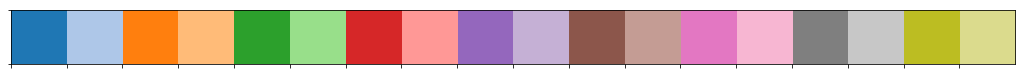

In [57]:
palette = sns.color_palette(palette='tab20', n_colors=len(c)+1)

sns.palplot(palette)
print('  ', '  ||  '.join([str(i) for i in list(range(1,len(c)+1))]))

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


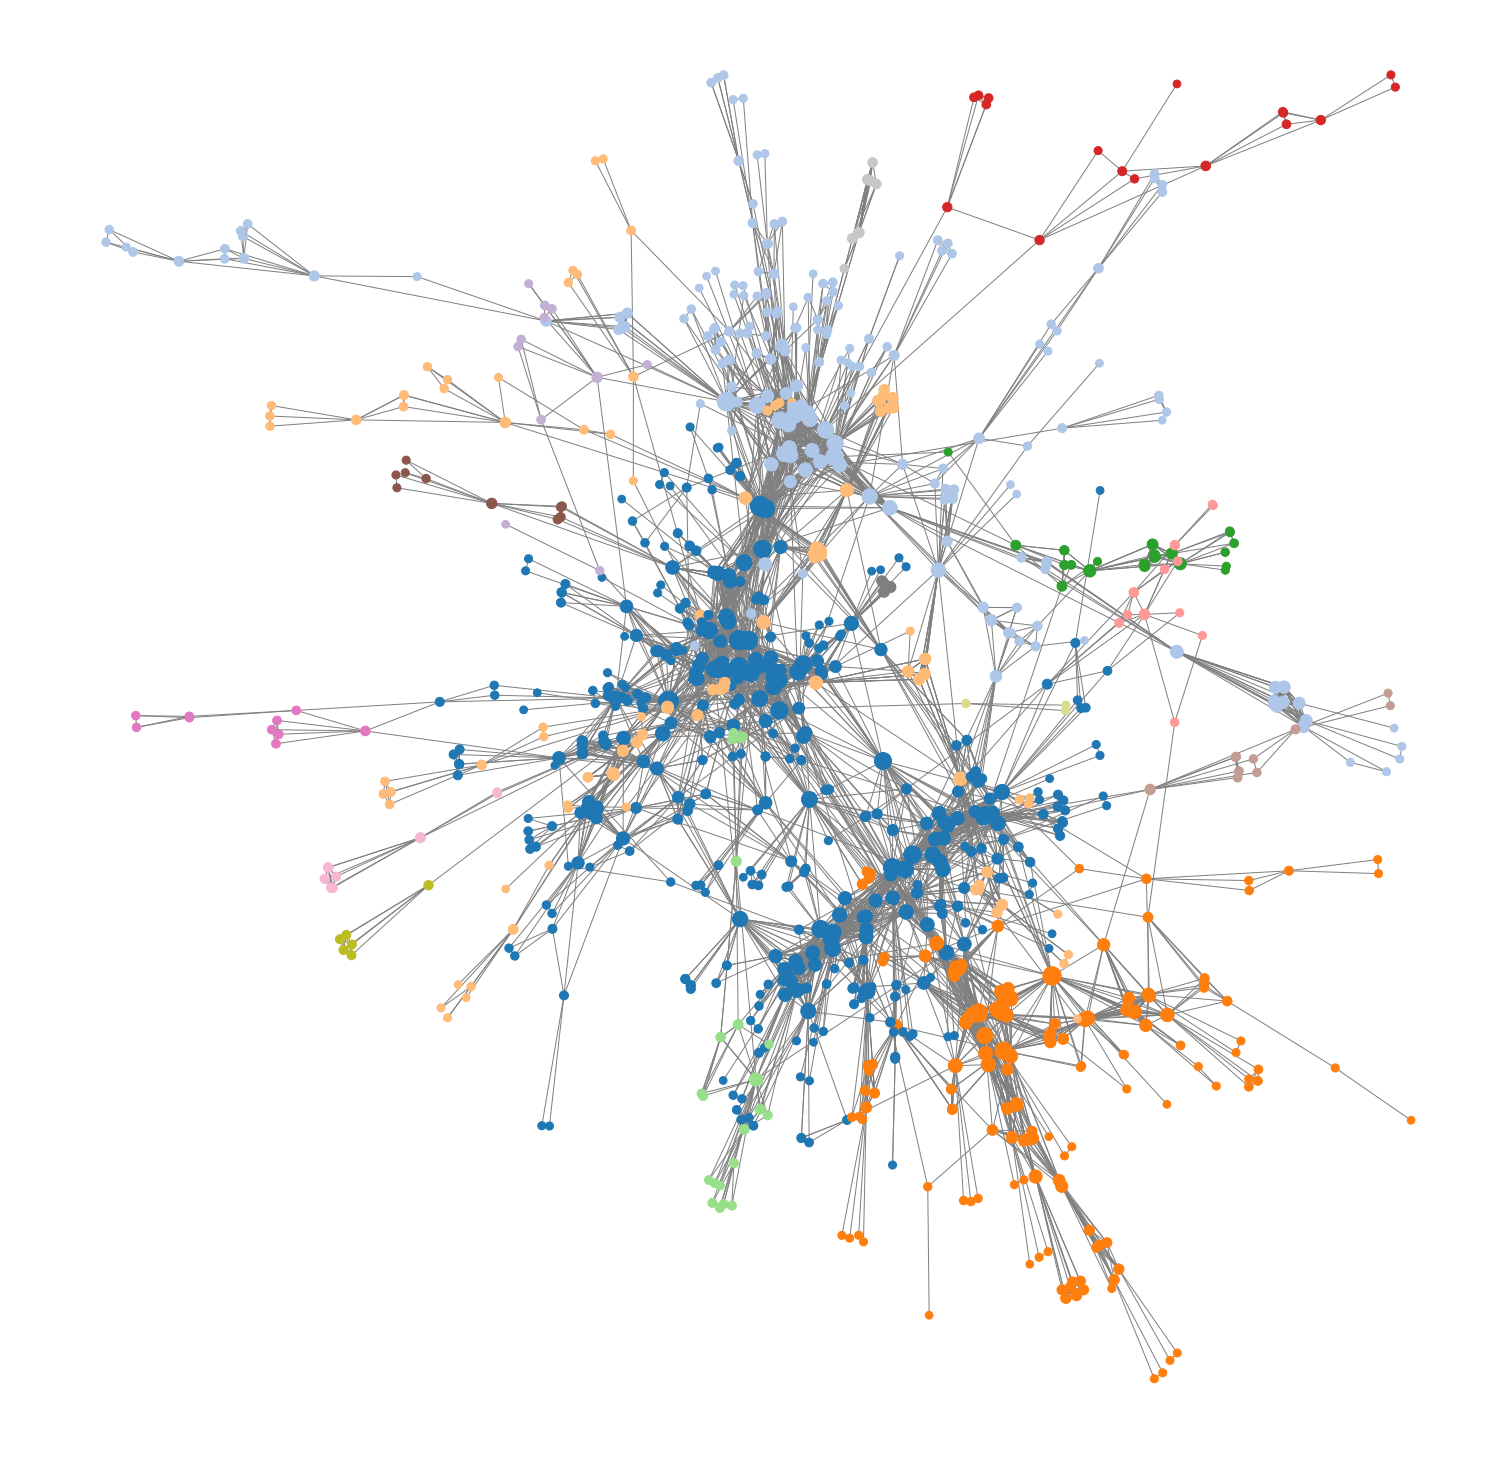

In [58]:
plt.figure(figsize=(20, 20))

nx.draw_spring(main_component, node_color=node_colors, 
                       cmap=ListedColormap(palette.as_hex()),
                       node_size=(node_size+node_size.mean())*6000,
                       #labels=labels,
               edge_color='grey',
               iterations=400
              )

plotting this geographically, we see that there is no clear geographical clustering belonging to these commuitues!

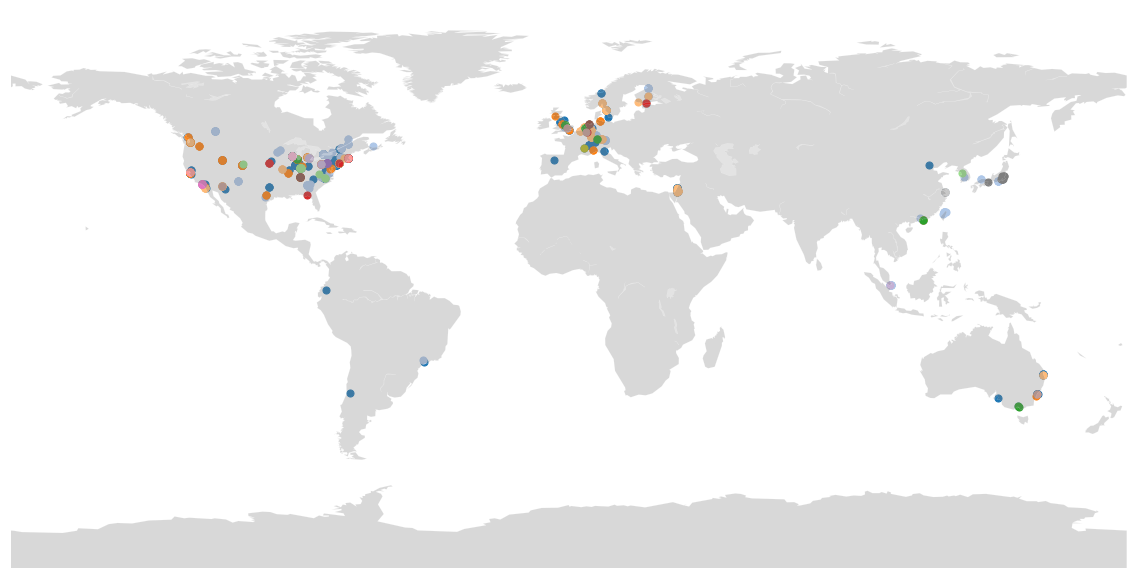

In [59]:
plt.figure(figsize=(20, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
for i,cluster in enumerate(c):
    data = nodes.iloc[list(cluster)].copy()
    m.scatter(data['Lon'], data['Lat'], s= 50, c= palette.as_hex()[i])

Here we have to code that allows to load this graph in Gephi.

As this graph is quite large, we build a smaller graph by cutting off outer nodes, and looking into the connector nodes:

In [60]:
G = nx.k_core(main_component, 12)

In [61]:
node_colors = pd.Series(member_label)[list(G.nodes())].sort_index().tolist()
node_size = np.array(list(nx.betweenness_centrality(G).values()))

In [62]:
people = pd.Series(mapping) 

In [63]:
persons_of_interest = pd.DataFrame(people[list(G.nodes())]).copy()
persons_of_interest['centrality'] = node_size

In [64]:
persons_of_interest.centrality.quantile(.95)

0.06903570513756488

In [65]:
labels = persons_of_interest[persons_of_interest.centrality > persons_of_interest.centrality.quantile(.92)]
labels = labels[0]
labels = labels.to_dict()

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


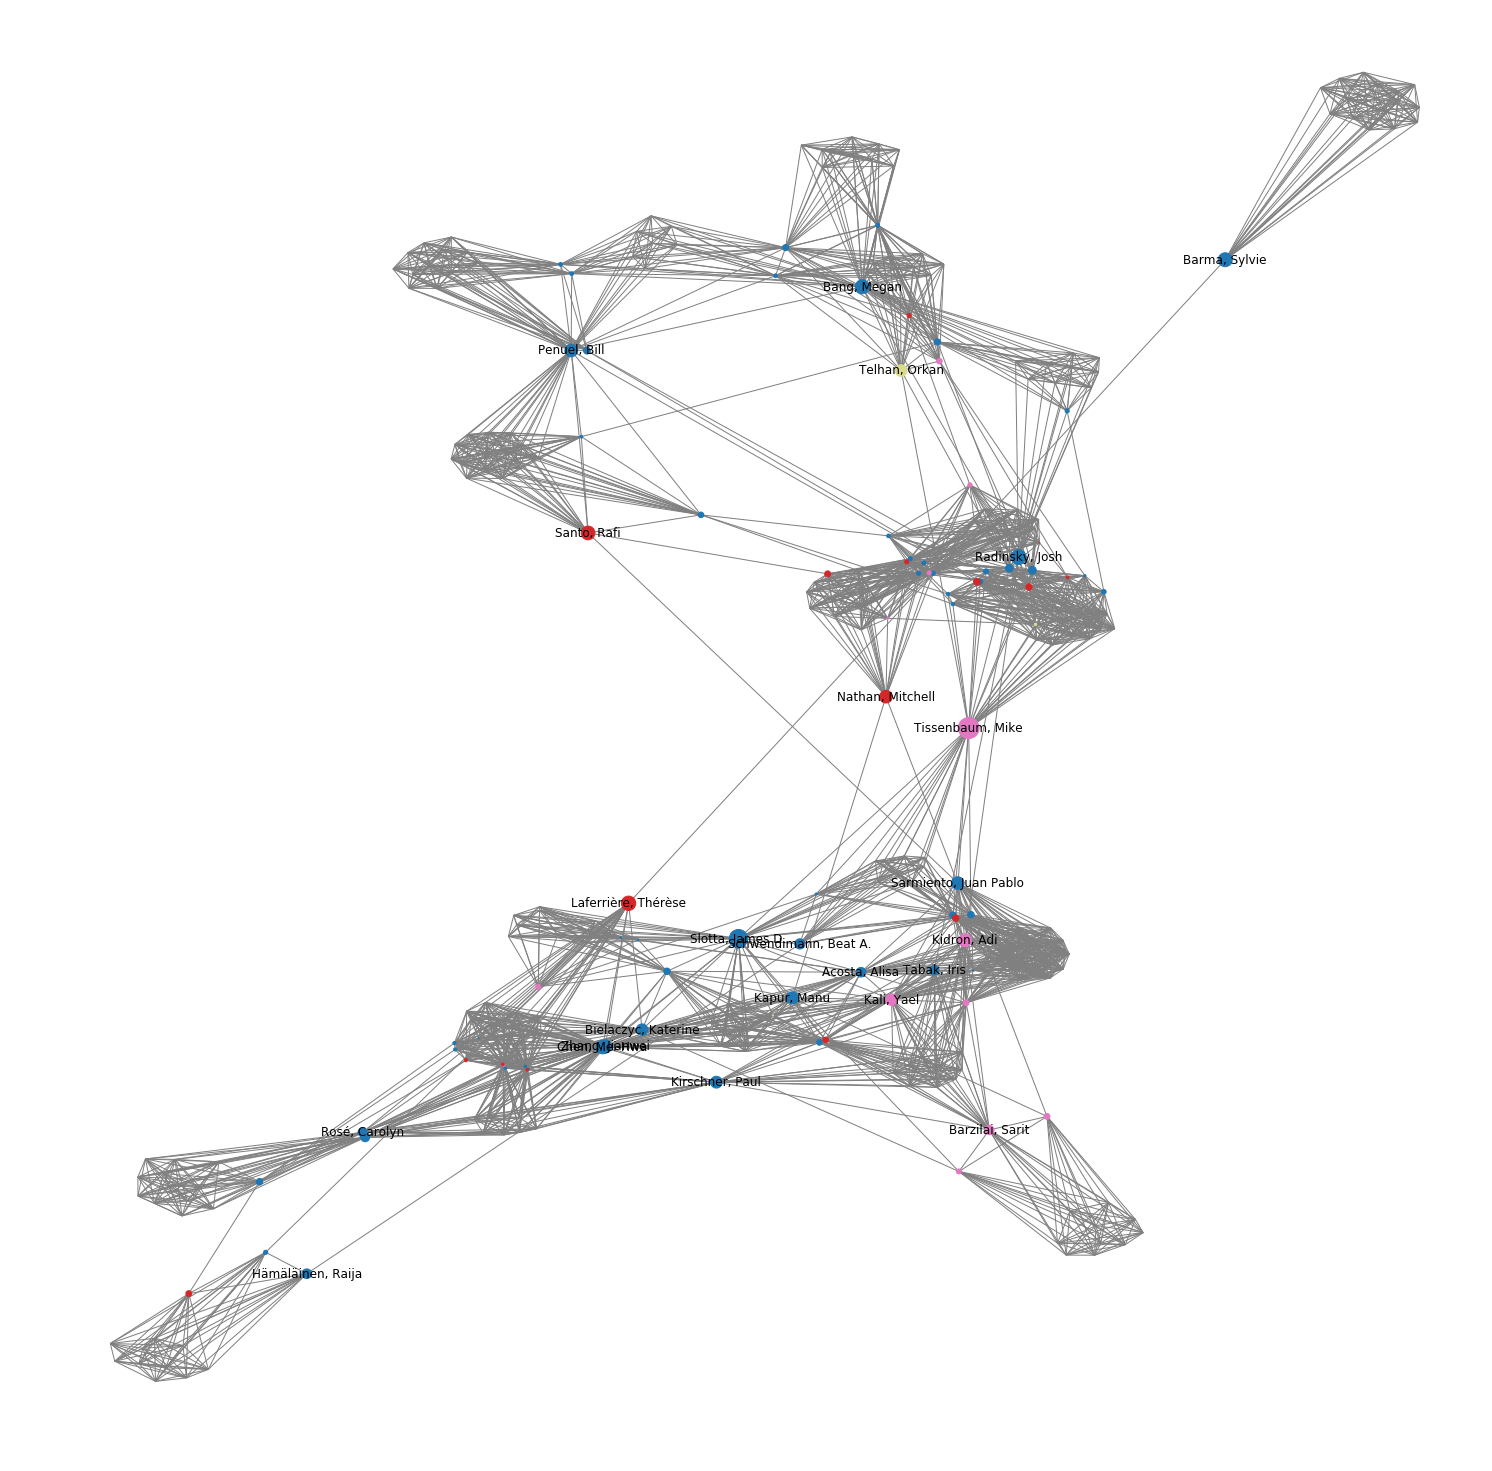

In [66]:
plt.figure(figsize=(20, 20))
nx.draw_spring(G, 
               node_color=node_colors, 
               cmap=ListedColormap(palette.as_hex()),
               node_size=node_size*2000,
                labels=labels,
               edge_color='grey',
               iterations=1000
              )

In [67]:
nx.set_node_attributes(main_component, nodes.country.to_dict(), name='country')
nx.set_node_attributes(main_component, nodes.name.to_dict(), name='uni')
nx.set_node_attributes(main_component, nx.degree_centrality(graph), name='centrality')

#mapping = nodes.long_name.to_dict()
#main_component_names =nx.relabel_nodes(main_component,mapping)
#nx.write_gexf(H, 'data/main_coauthor_graph.gexf')
#nx.write_gpickle(main_component_names, 'data/coauthor_graph')

### Analyzing each subcomponent

We look at distribution of country and inst. inside these clusters (my it's associated members):

In [68]:
c = [x for x in c if len(x) > 20]

Cluster dist for cluster 1


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


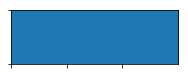

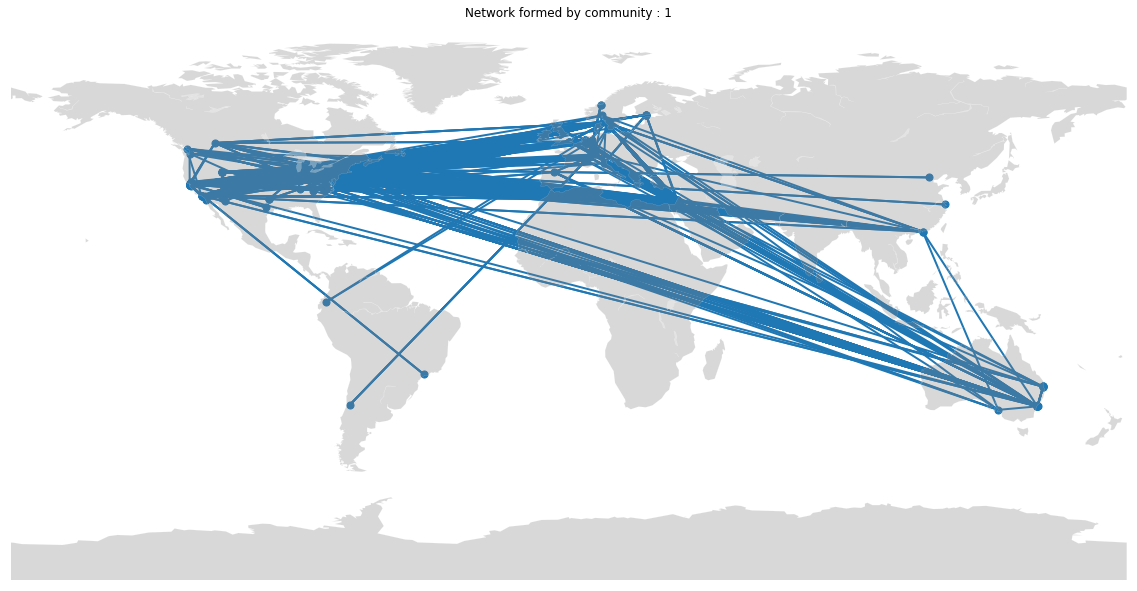

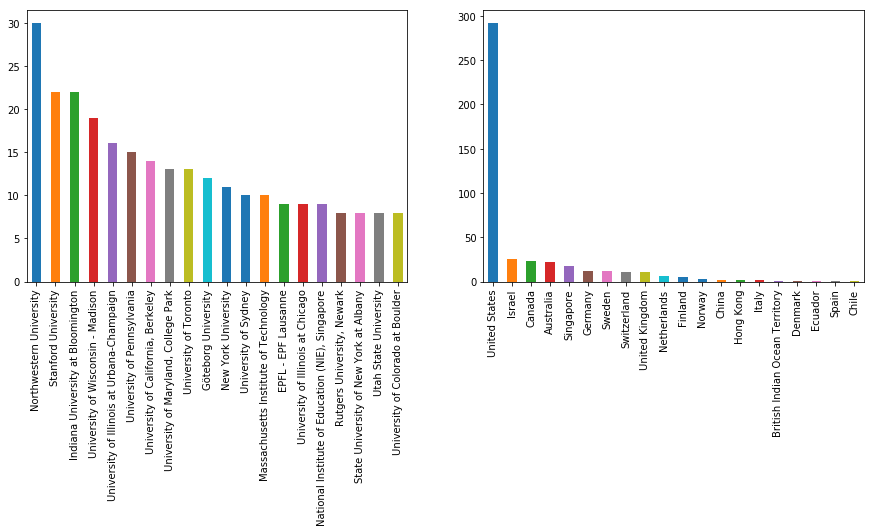

Number of countries in cluster:  22
Number of institutions in cluster:  99
Number of people in cluster:  452


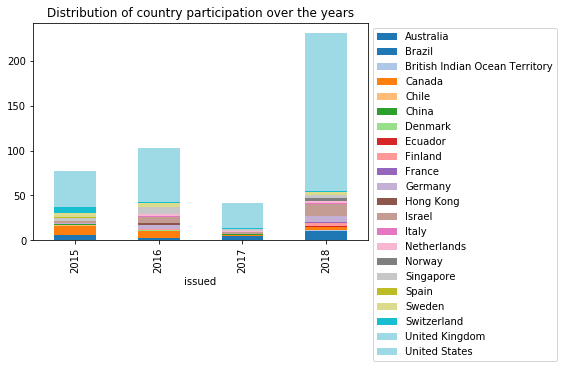

Cluster dist for cluster 2


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


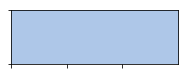

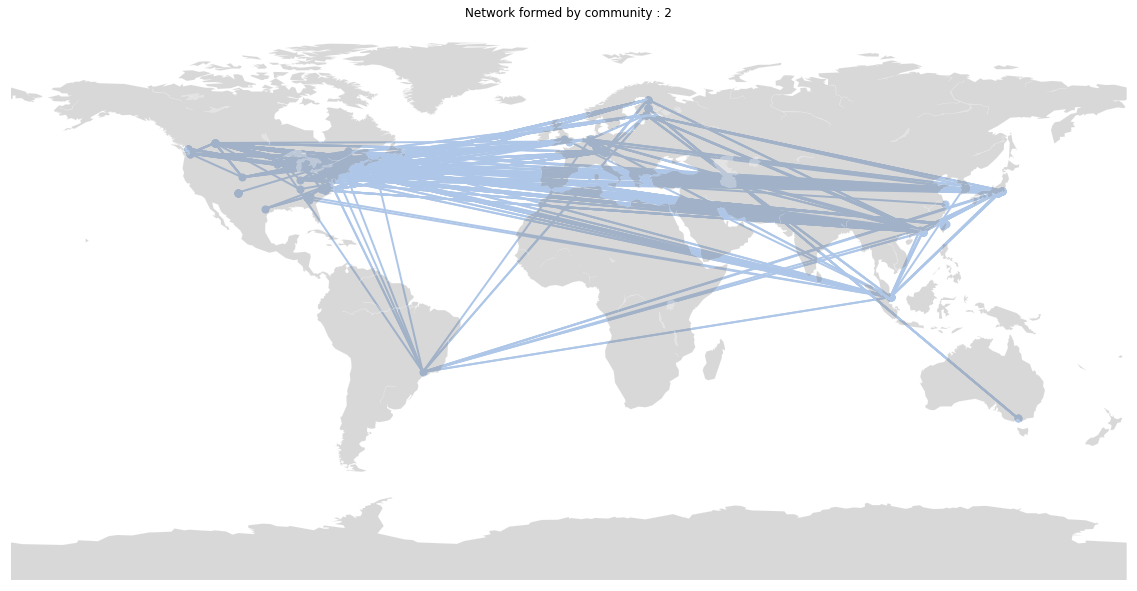

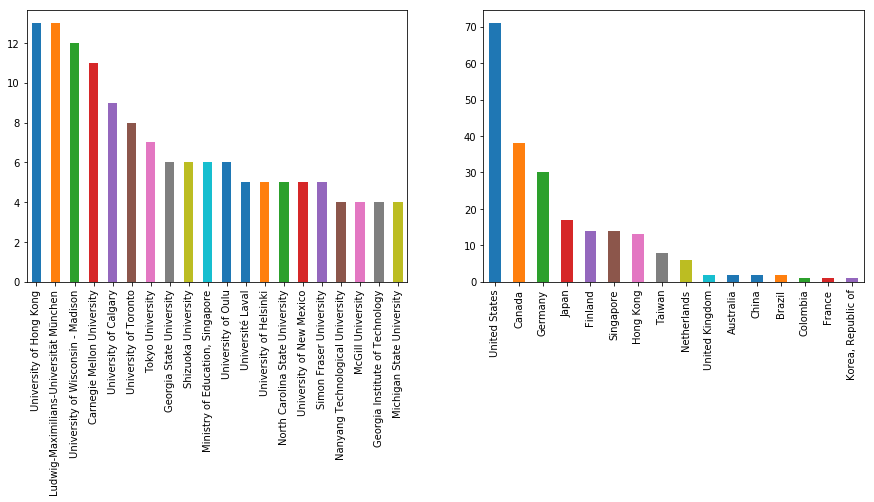

Number of countries in cluster:  16
Number of institutions in cluster:  73
Number of people in cluster:  222


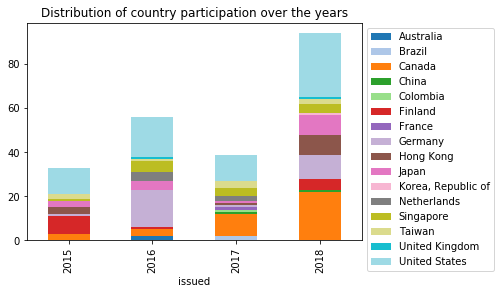

Cluster dist for cluster 3


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


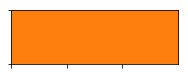

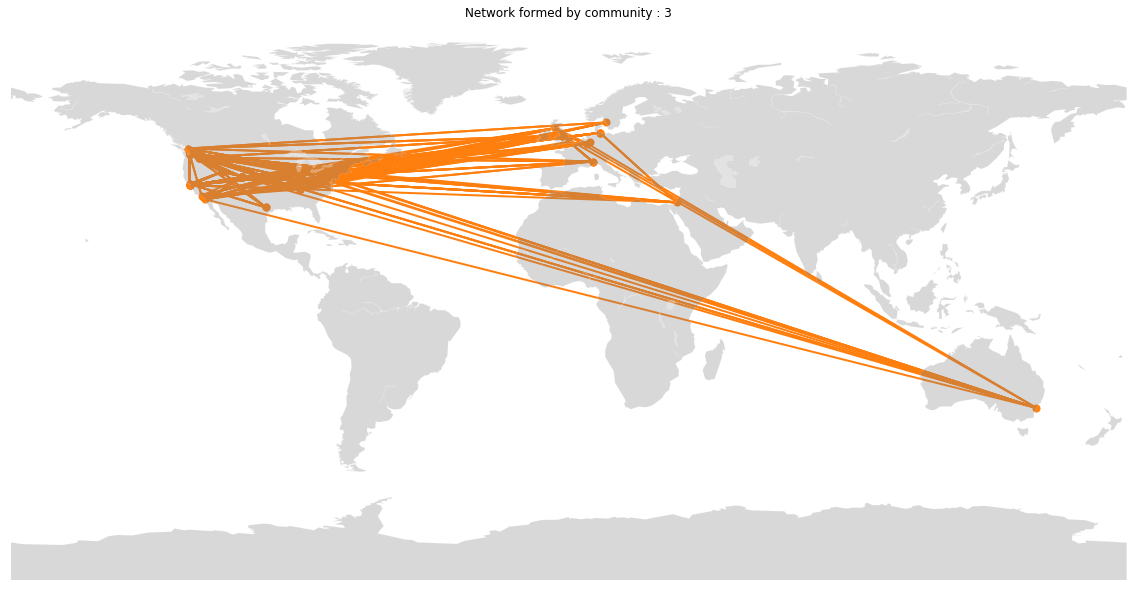

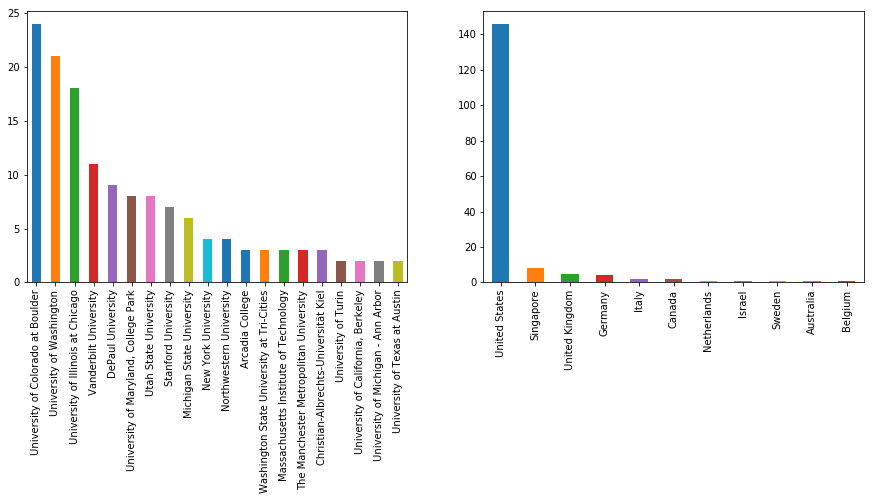

Number of countries in cluster:  11
Number of institutions in cluster:  40
Number of people in cluster:  172


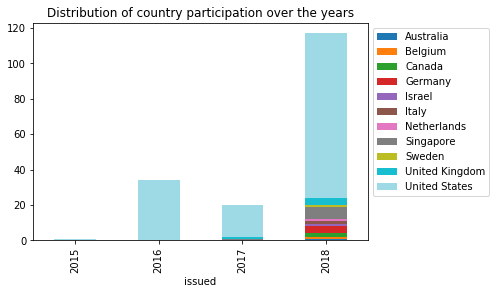

Cluster dist for cluster 4


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


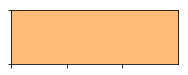

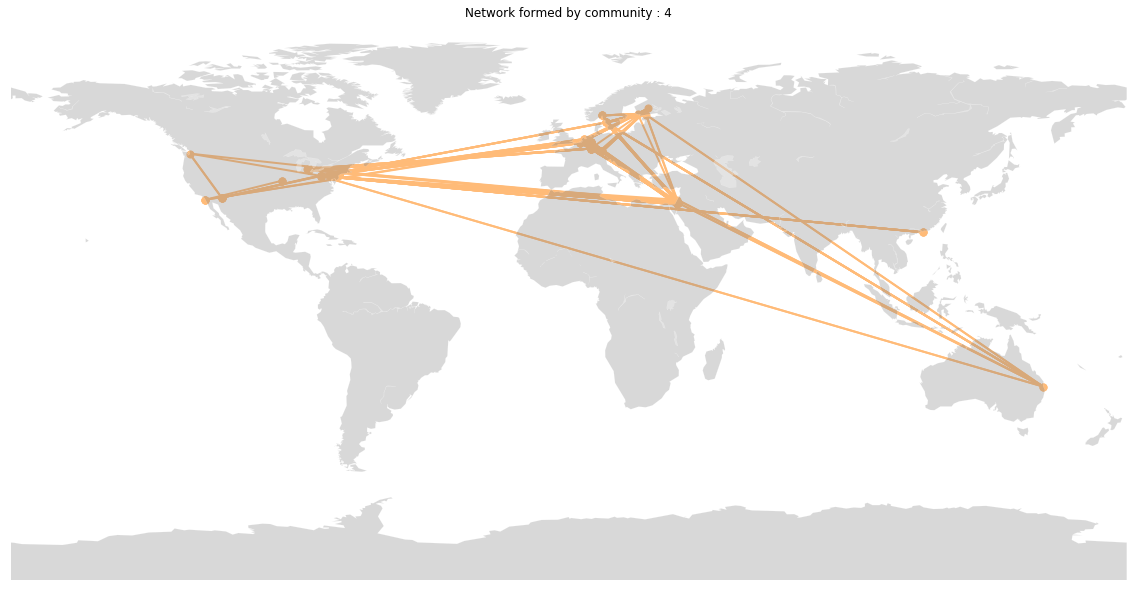

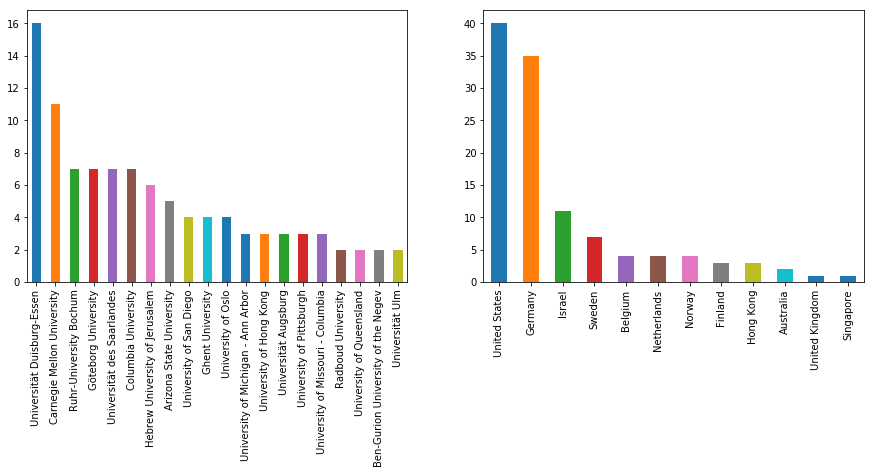

Number of countries in cluster:  12
Number of institutions in cluster:  32
Number of people in cluster:  115


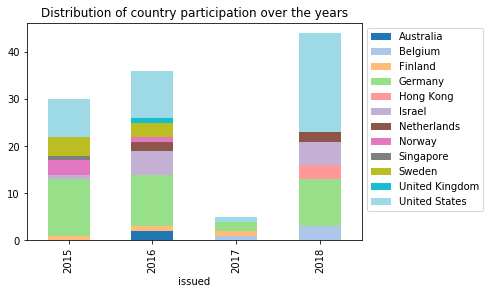

Cluster dist for cluster 5


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


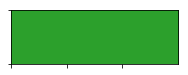

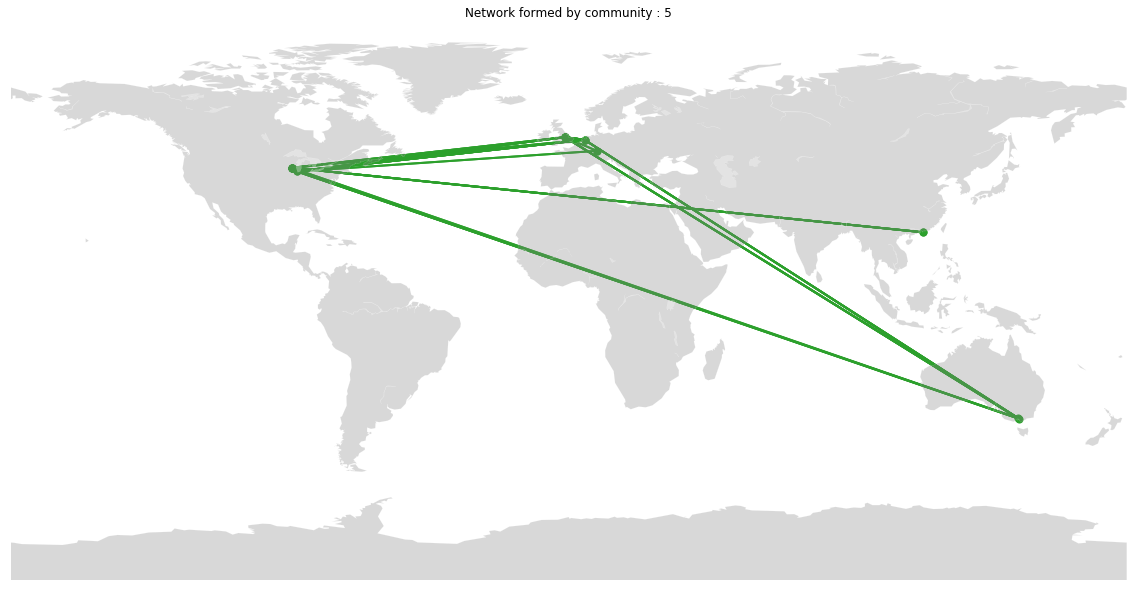

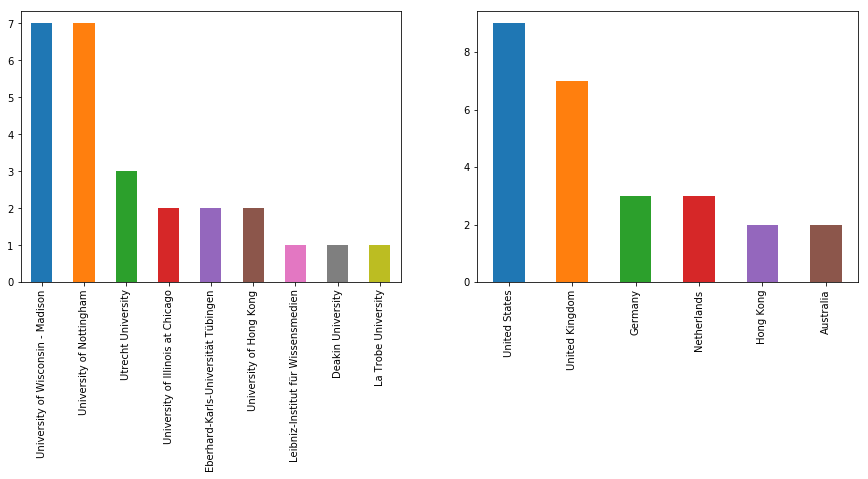

Number of countries in cluster:  6
Number of institutions in cluster:  9
Number of people in cluster:  26


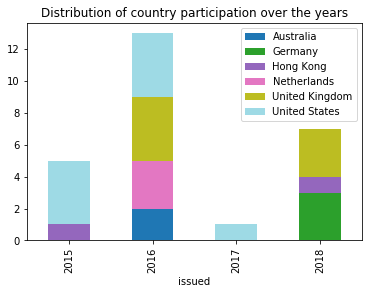

Cluster dist for cluster 6


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


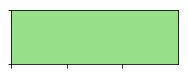

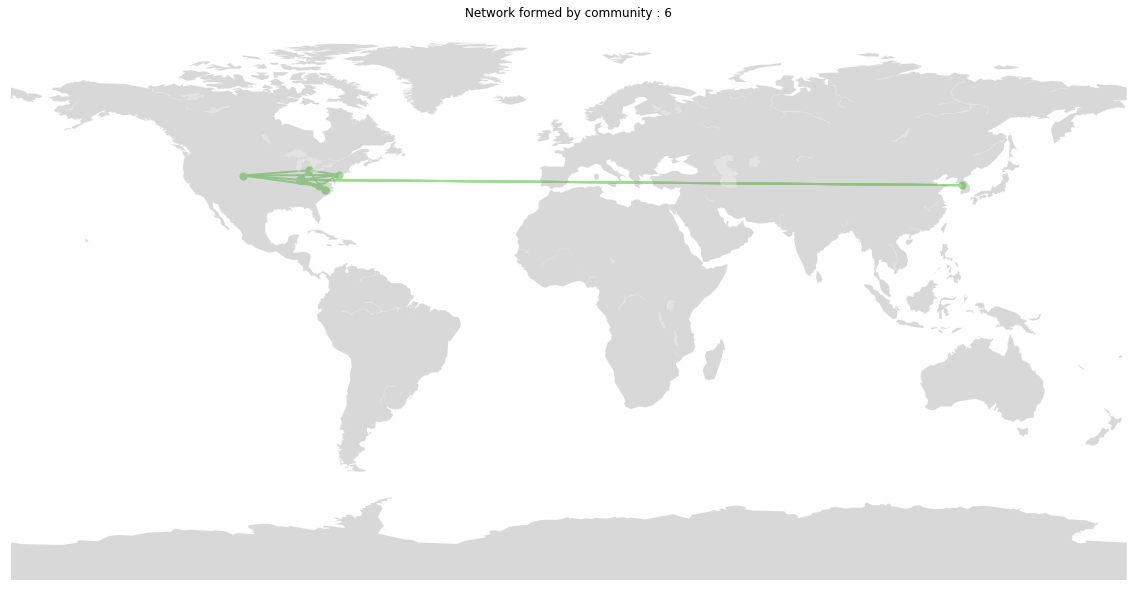

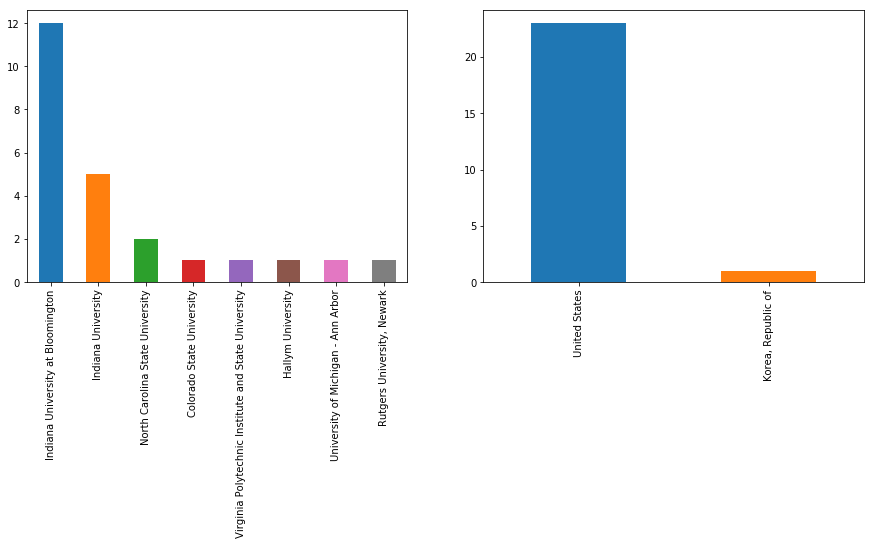

Number of countries in cluster:  2
Number of institutions in cluster:  8
Number of people in cluster:  24


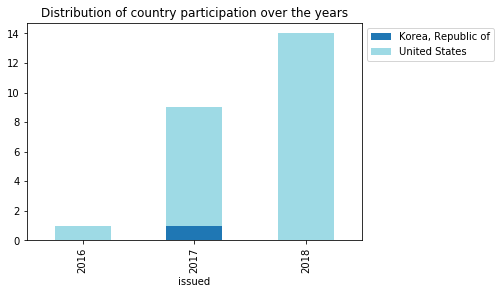

In [69]:
for i,cluster in enumerate(c):
    print(f'Cluster dist for cluster {i+1}')
    sns.palplot(palette[i])
    
    plt.figure(figsize=(20, 20))
    data = nodes.iloc[list(cluster)].copy()
    draw_map_plot(data, palette.as_hex()[i])


    embedding = data.apply(lambda x: [x.Lon, x.Lat], axis=1)
    nx.draw_networkx_edges(main_component.subgraph(cluster),  pos = embedding, 
                           edge_color=palette.as_hex()[i], width = 2)
    
    plt.title('Network formed by community : {}'.format(i+1))
    plt.show()
    
    #adding inner cluster distribution plot
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    nodes.iloc[list(cluster)].name.value_counts().head(20).plot('bar')
    plt.subplot(122)
    nodes.iloc[list(cluster)].country.value_counts().head(20).plot('bar')
    plt.show()
    
    #getting some concrete values
    print('Number of countries in cluster: ', len(nodes.iloc[list(cluster)].country.unique()))
    print('Number of institutions in cluster: ', len(nodes.iloc[list(cluster)].name.unique()))
    print('Number of people in cluster: ', len(nodes.iloc[list(cluster)].long_name.unique()))
    
    #plt.title('Number of people submitting over the years over the years')
    
   
    plot_df = pd.DataFrame(nodes.iloc[list(cluster)].groupby(['issued'])\
                           .country.value_counts()).rename(columns={'country':'count'}).reset_index()
    plot_df.pivot(index='issued', columns='country', values='count').plot(kind='bar', stacked=True, colormap=plt.cm.tab20)
    plt.title('Distribution of country participation over the years')
    plt.legend(bbox_to_anchor=(1, 1))
    
    plt.show()    
    


## An other way to partition the graph: Hierarchical clustering

NOT DONE YET

## Looking at people moving around

We now look at people who moved from one country to an other within the period of the papers in the parsed papers:

We have to look at years as well to avoid duplicates, however, this could be due to people being associated to multiple institutions at once.

In [70]:
name_country = associations[['name', 'mail', 'country', 'long_name', 'shortend_names','issued']]

In [71]:
#Add year to see
df = pd.merge(name_country, name_country, on='long_name').dropna()
df = df[df.country_x != df.country_y]
df['set_countries'] = df.apply(lambda x: ''.join(sorted([x.country_x, x.country_y, str(x.issued_x), str(x.issued_y)])), axis=1)
df[~df[['long_name', 'set_countries']].duplicated()].head()

name_x                    mail_x country_x  \
609  University of Toronto    jim.slotta@utoronto.ca    Canada   
619  University of Toronto    jim.slotta@utoronto.ca    Canada   
707  University of Toronto  alisa.acosta@utoronto.ca    Canada   
713  University of Toronto  alisa.acosta@utoronto.ca    Canada   
719  University of Toronto  alisa.acosta@utoronto.ca    Canada   

            long_name shortend_names_x  issued_x               name_y  \
609  Slotta, James D.     Slotta J. D.      2015       Boston College   
619  Slotta, James D.          Kali Y.      2016       Boston College   
707     Acosta, Alisa     Slotta J. D.      2015  New York University   
713     Acosta, Alisa    Charles E. S.      2016  New York University   
719     Acosta, Alisa        Acosta A.      2018  New York University   

             mail_y      country_y shortend_names_y  issued_y  \
609   slotta@bc.edu  United States         Moher T.      2017   
619   slotta@bc.edu  United States         Moher T.      2017   
707  th1425@nyu.edu  United States            Clark      2018   
713  th1425@nyu.edu  United States            Clark      2018   
719  th1425@nyu.edu  United States            Clark      2018   

                   set_countries  
609  20152017CanadaUnited States  
619  20162017CanadaUnited States  
707  20152018CanadaUnited States  
713  20162018CanadaUnited States  
719  20182018CanadaUnited States

In [72]:
df = pd.merge(name_country, name_country, on='long_name').dropna()
df['set_countries'] = df.apply(lambda x: ''.join(sorted([x.name_x, x.name_y, str(x.issued_x), str(x.issued_y)])), axis=1)
df = df[~df[['long_name', 'set_countries']].duplicated()]
df[(df.name_x != df.name_y) & (df.country_x != df.country_y)][['long_name','shortend_names_y', 'name_x', 'name_y', 'issued_x', 'issued_y']].head(3)

long_name shortend_names_y  \
609  Slotta, James D.         Moher T.   
619  Slotta, James D.         Moher T.   
639  Slotta, James D.         Moher T.   

                                                name_x          name_y  \
609                              University of Toronto  Boston College   
619                              University of Toronto  Boston College   
639  Ontario Institute for Studies in Education, Un...  Boston College   

     issued_x  issued_y  
609      2015      2017  
619      2016      2017  
639      2016      2017

Number of people that changed organisation:

#TODO fix years

In [73]:
df[(df.name_x != df.name_y) & (df.country_x == df.country_y)].drop_duplicates().head()

name_x                            mail_x  \
100  Indiana University at Bloomington               agomoll90@gmail.com   
104  Indiana University at Bloomington               agomoll@indiana.edu   
243           Georgia State University               lmargulieux@gsu.edu   
245           Georgia State University               lmargulieux@gsu.edu   
285               Universität Augsburg  ingo.kollar@phil.uni-augsburg.de   

         country_x              long_name  shortend_names_x  issued_x  \
100  United States   Gomoll, Andrea Sarah      Gomoll A. S.      2018   
104  United States   Gomoll, Andrea Sarah      Gomoll A. S.      2016   
243  United States  Margulieux, Lauren E.  Margulieux L. E.      2018   
245  United States  Margulieux, Lauren E.  Margulieux L. E.      2018   
285        Germany           Kollar, Ingo         Kollar I.      2016   

                                     name_y                  mail_y  \
100                      Indiana University          agomoll@iu.edu   
104                      Indiana University          agomoll@iu.edu   
243         Georgia Institute of Technology       l.marg@gatech.edu   
245         Georgia Institute of Technology       l.marg@gatech.edu   
285  Ludwig-Maximilians-Universität München  ingo.kollar@psy.lmu.de   

         country_y  shortend_names_y  issued_y  \
100  United States      Gomoll A. S.      2018   
104  United States      Gomoll A. S.      2018   
243  United States  Margulieux L. E.      2015   
245  United States  Margulieux L. E.      2016   
285        Germany         Kollar I.      2015   

                                         set_countries  
100  20182018Indiana UniversityIndiana University a...  
104  20162018Indiana UniversityIndiana University a...  
243  20152018Georgia Institute of TechnologyGeorgia...  
245  20162018Georgia Institute of TechnologyGeorgia...  
285  20152016Ludwig-Maximilians-Universität München...

## Looking at the network over the years

One interessting observation is that the ICLS years are much more dense and connected.

In [74]:
associations.issued.unique()

array([2018, 2016, 2015, 2017])

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


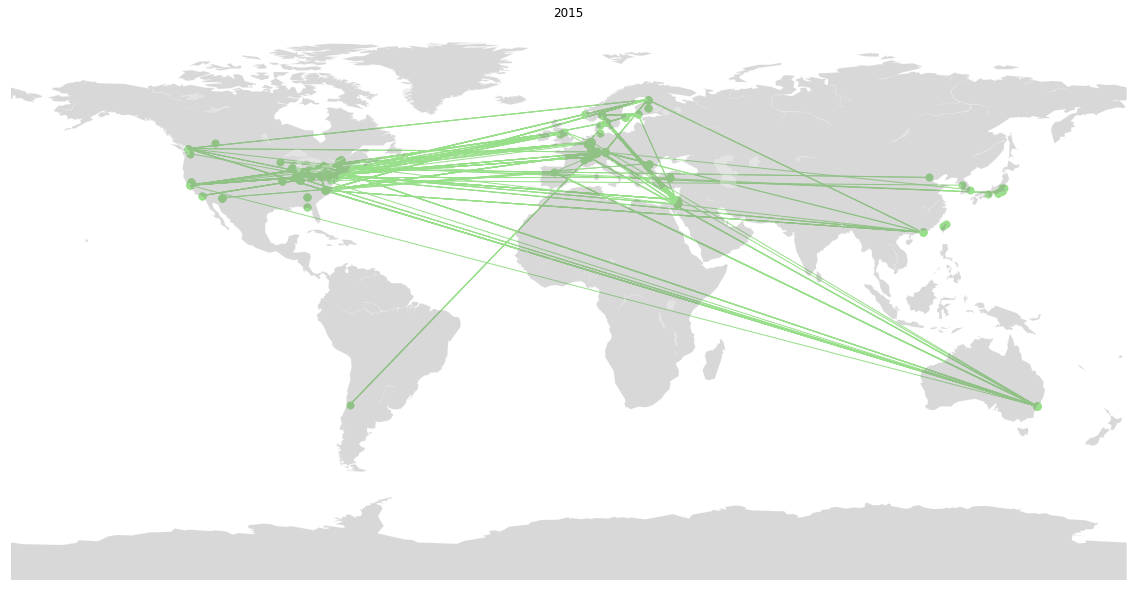

Density of the graph :  0.02257004927089036
The largest component has  58 nodes accounting for 20.42 % of the nodes
The diameter of the largest component is 6
Attribute Assortativity coef: Country:  0.4872566111993371
Attribute Assortativity coef: Uni:  0.35192279075432975


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


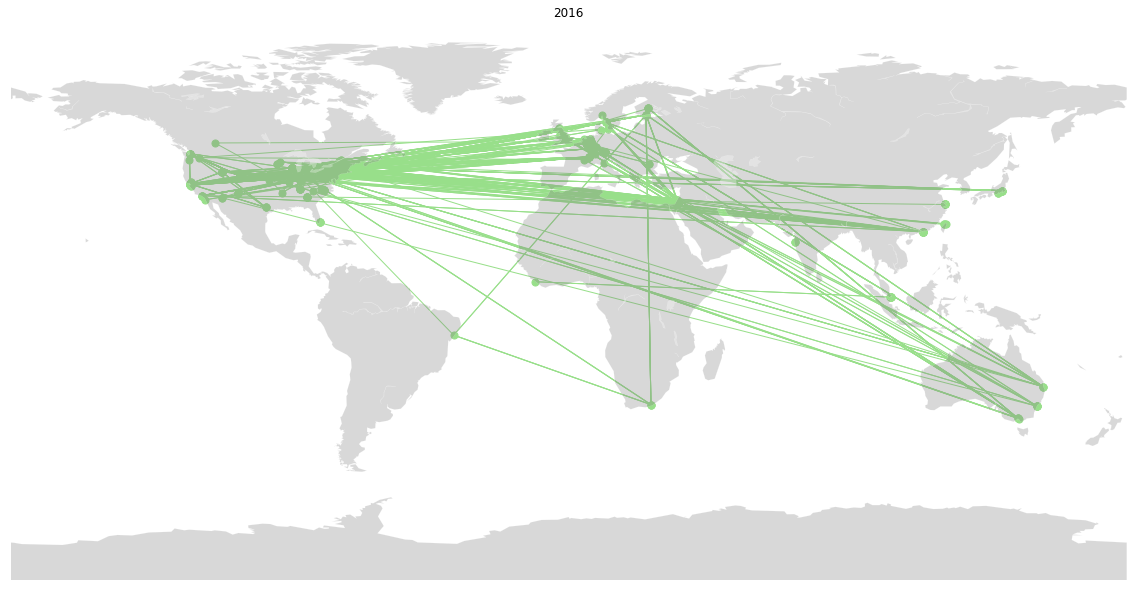

Density of the graph :  0.011657958982433539
The largest component has  105 nodes accounting for 20.92 % of the nodes
The diameter of the largest component is 7
Attribute Assortativity coef: Country:  0.46519228641570687
Attribute Assortativity coef: Uni:  0.3833474734949293


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


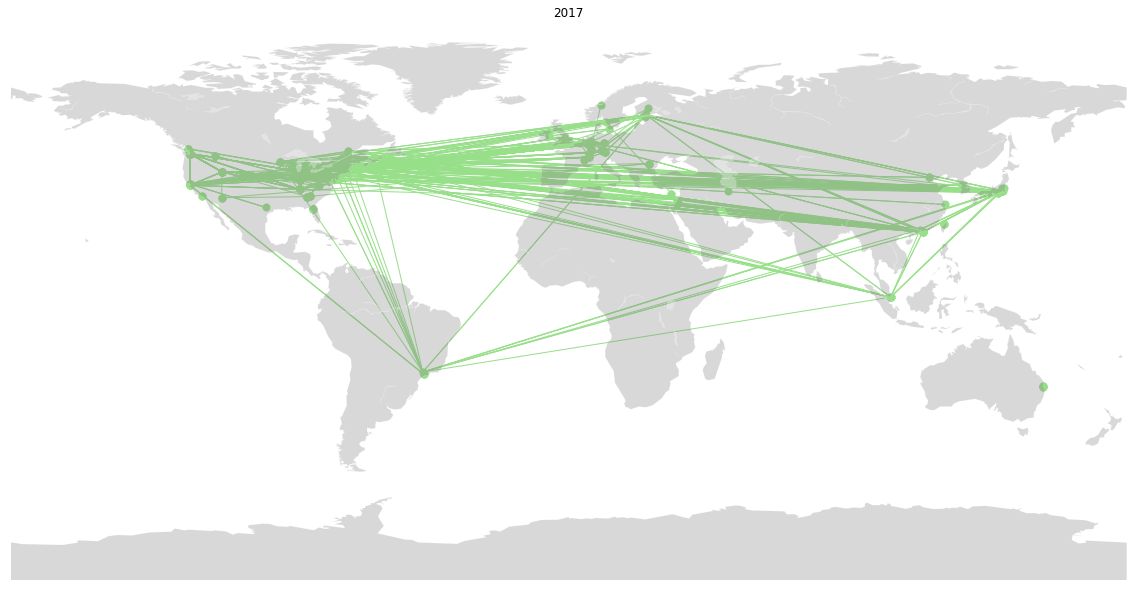

Density of the graph :  0.01702127659574468
The largest component has  73 nodes accounting for 19.41 % of the nodes
The diameter of the largest component is 6
Attribute Assortativity coef: Country:  0.3852704866989518
Attribute Assortativity coef: Uni:  0.2765263915195177


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


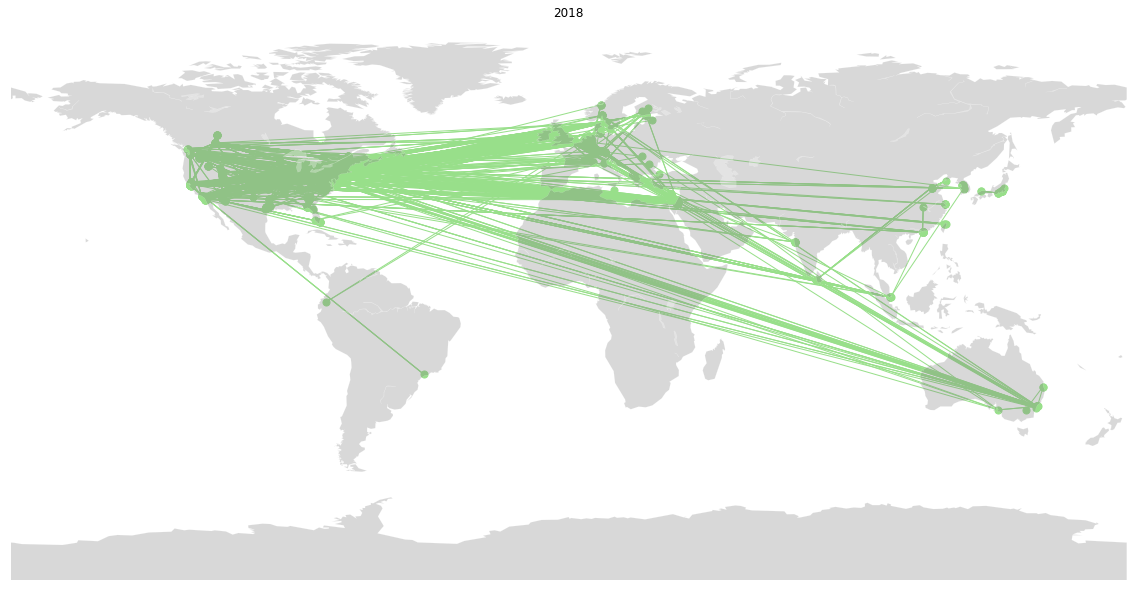

Density of the graph :  0.005508196304229258
The largest component has  411 nodes accounting for 36.63 % of the nodes
The diameter of the largest component is 12
Attribute Assortativity coef: Country:  0.4462884024370008
Attribute Assortativity coef: Uni:  0.32762263808761016


In [75]:
for year in sorted(associations.issued.unique()):

    
    #getting the data in shape to build the graph
    year_assoc = associations[(associations.country.notna()) & (associations.issued==year)]

    self_merge = pd.merge(year_assoc, year_assoc, on='file')
    self_merge = self_merge[self_merge.long_name_x != self_merge.long_name_y]


    nodes = year_assoc[~year_assoc.long_name.duplicated()].reset_index(drop=True).reset_index()
    name_index = nodes.long_name.to_dict()
    name_index = {v: k for k, v in name_index.items()}

    self_merge['source'] = self_merge.long_name_x.map(name_index)
    self_merge['target'] = self_merge.long_name_y.map(name_index)

    #building the graph
    adjacency = get_adjacency(nodes, self_merge)
    graph = nx.from_numpy_array(adjacency)

    #plot the map
    plt.figure(figsize=(20, 20))
    plt.title(year)
    data = nodes.copy()
    draw_map_plot(data, palette.as_hex()[i])


    #add the graph on top
    embedding = nodes.apply(lambda x: [x.Lon, x.Lat], axis=1)
    nx.draw_networkx_edges(graph,  pos = embedding, 
                           edge_color=palette.as_hex()[i], width = 1)
    plt.show()   
    
    
    #calculate graph theoretical measures
    nx.set_node_attributes(graph, nodes.country.to_dict(), name='country')
    nx.set_node_attributes(graph, nodes.name.to_dict(), name='uni')
    nx.set_node_attributes(graph, nx.degree_centrality(graph), name='centrality')

    print('Density of the graph : ' , nx.density(graph))
    comp = list(nx.connected_components(graph))
    largest_comp = max(comp, key=len)
    percentage_lcc = len(largest_comp)/ graph.number_of_nodes() * 100
    print('The largest component has ',
          len(largest_comp), 'nodes',
          'accounting for %.2f'% percentage_lcc, 
          '% of the nodes')
    lcc = graph.subgraph(largest_comp)
    diameter = nx.diameter(lcc)
    print("The diameter of the largest component is", diameter)
    print('Attribute Assortativity coef: Country: ', nx.attribute_assortativity_coefficient(graph, 'country'))
    print('Attribute Assortativity coef: Uni: ', nx.attribute_assortativity_coefficient(graph, 'uni'))
    

From the above we can deduce that:
1. the community is becomming less tight knit by the year (Density of graph, Diameter, Largest component)
2. something weird is going on in 2017, why is largest commponent so smal
3. There seems to be no string geographical linkage (country/uni) for collaboration (Attribute Assorativity Coefficient), which gives us how likely two nodes are linked given that they have the same attribute (country/uni)

## ICLS vs CSCL:

In [76]:
(associations.issued % 2 == 1).sum()

1088

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


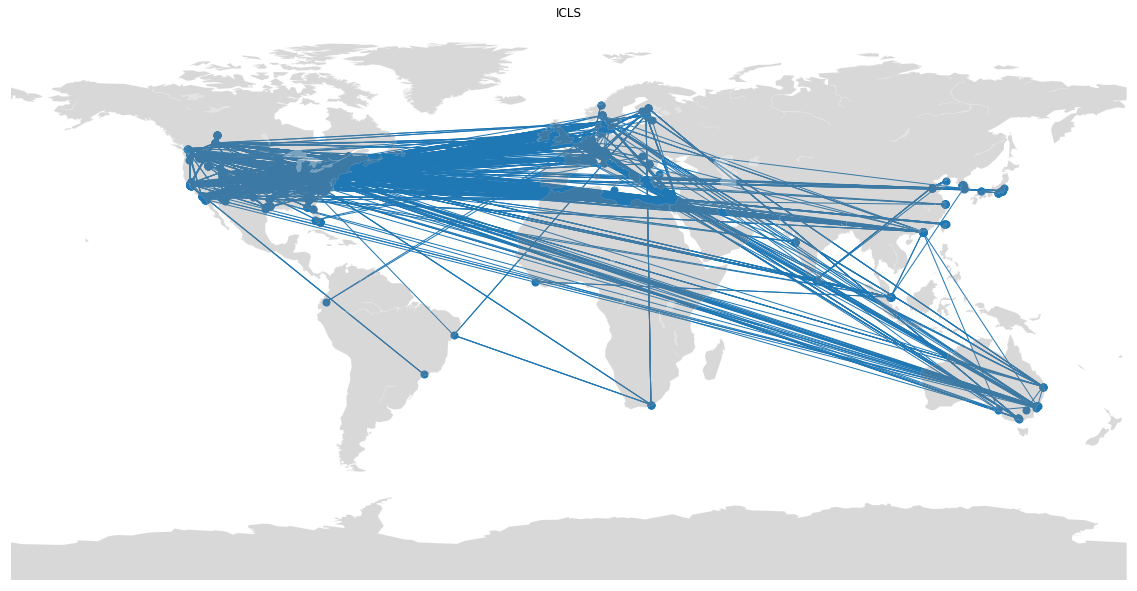

Density of the graph :  0.004721380788560635
The largest component has  800 nodes accounting for 55.94 % of the nodes
The diameter of the largest component is 14
Attribute Assortativity coef: Country:  0.4410538262139249
Attribute Assortativity coef: Uni:  0.3350286597574825


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


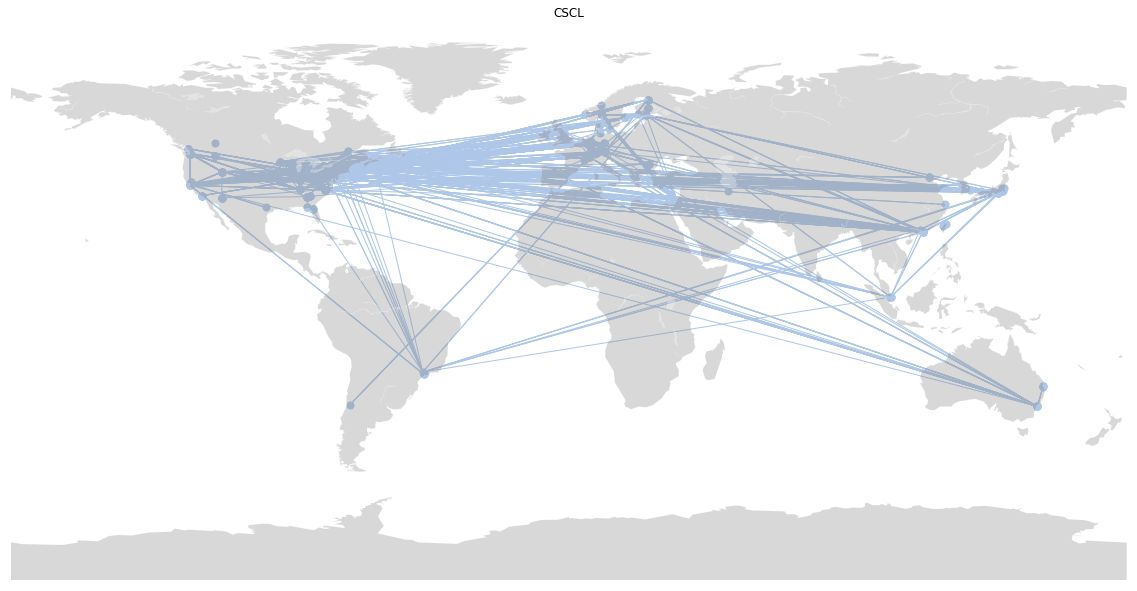

Density of the graph :  0.012059910523244505
The largest component has  148 nodes accounting for 25.39 % of the nodes
The diameter of the largest component is 8
Attribute Assortativity coef: Country:  0.43133937501894337
Attribute Assortativity coef: Uni:  0.3045967405388235


In [77]:
for i, title in enumerate(['ICLS', 'CSCL']):

    year_assoc = associations[(associations.issued % 2 == i)]

    self_merge = pd.merge(year_assoc, year_assoc, on='file')
    self_merge = self_merge[self_merge.long_name_x != self_merge.long_name_y]

    #edges = self_merge[['long_name_x', 'long_name_y', 'issued_x']].copy()

    nodes = year_assoc[~year_assoc.long_name.duplicated()].reset_index(drop=True).reset_index()
    name_index = nodes.long_name.to_dict()
    name_index = {v: k for k, v in name_index.items()}

    self_merge['source'] = self_merge.long_name_x.map(name_index)
    self_merge['target'] = self_merge.long_name_y.map(name_index)

    adjacency = get_adjacency(nodes, self_merge)
    graph = nx.from_numpy_array(adjacency)

    plt.figure(figsize=(20, 20))
    plt.title(title)
    data = nodes.copy()
    draw_map_plot(data, palette.as_hex()[i])


    embedding = nodes.apply(lambda x: [x.Lon, x.Lat], axis=1)
    nx.draw_networkx_edges(graph,  pos = embedding, 
                           edge_color=palette.as_hex()[i], width = 1)
    plt.show()   

    nx.set_node_attributes(graph, nodes.country.to_dict(), name='country')
    nx.set_node_attributes(graph, nodes.name.to_dict(), name='uni')
    nx.set_node_attributes(graph, nx.degree_centrality(graph), name='centrality')


    print('Density of the graph : ' , nx.density(graph))
    
    
    comp = list(nx.connected_components(graph))
    largest_comp = max(comp, key=len)
    
    percentage_lcc = len(largest_comp)/ graph.number_of_nodes() * 100
    print('The largest component has ',
          len(largest_comp), 'nodes',
          'accounting for %.2f'% percentage_lcc, 
          '% of the nodes')
    
    lcc_quak = graph.subgraph(largest_comp)
    diameter = nx.diameter(lcc_quak)
    print("The diameter of the largest component is", diameter)
    print('Attribute Assortativity coef: Country: ', nx.attribute_assortativity_coefficient(graph, 'country'))
    print('Attribute Assortativity coef: Uni: ', nx.attribute_assortativity_coefficient(graph, 'uni'))
    



From the path length in the largest component we see that the core-cummunity (as given by collaboration) of CSCL seems to be much more close knit than the icls community. Looking at the previous graphs with separation by years this may partially be due to the many new participants in 2018's icls, but as 2016's icls also has a larger diameter, this might be an underlying pattern that could be confirmed with more data.

## Re-examining 2018: how do nodes join?

In [78]:
previous_participation = set(associations[~associations.issued.isin([2018])].long_name.tolist())

year_assoc = associations[(associations.Lon.notna()) & (associations.issued == 2018)].copy()

year_assoc['prev'] = 0
year_assoc.loc[year_assoc.long_name.isin(previous_participation),'prev'] = 1

self_merge = pd.merge(year_assoc, year_assoc, on='file')
self_merge = self_merge[(self_merge.long_name_x != self_merge.long_name_y)]


nodes = year_assoc[~year_assoc.long_name.duplicated()].reset_index(drop=True).reset_index()
nodes = nodes[nodes.Lon.notna()]

name_index = nodes.long_name.to_dict()
name_index = {v: k for k, v in name_index.items()}



self_merge['source'] = self_merge.long_name_x.map(name_index)
self_merge['target'] = self_merge.long_name_y.map(name_index)


adjacency = get_adjacency(nodes, self_merge)
graph = nx.from_numpy_array(adjacency)

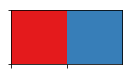

In [79]:
palette = sns.color_palette(palette='Set1', n_colors=2)

sns.palplot(palette)

We see that some of the new nodes joining in 2018 partly attach to people who already have participated in the conference in pervious years, while others join independently.

In red we have ned nodes, blue for old nodes.

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


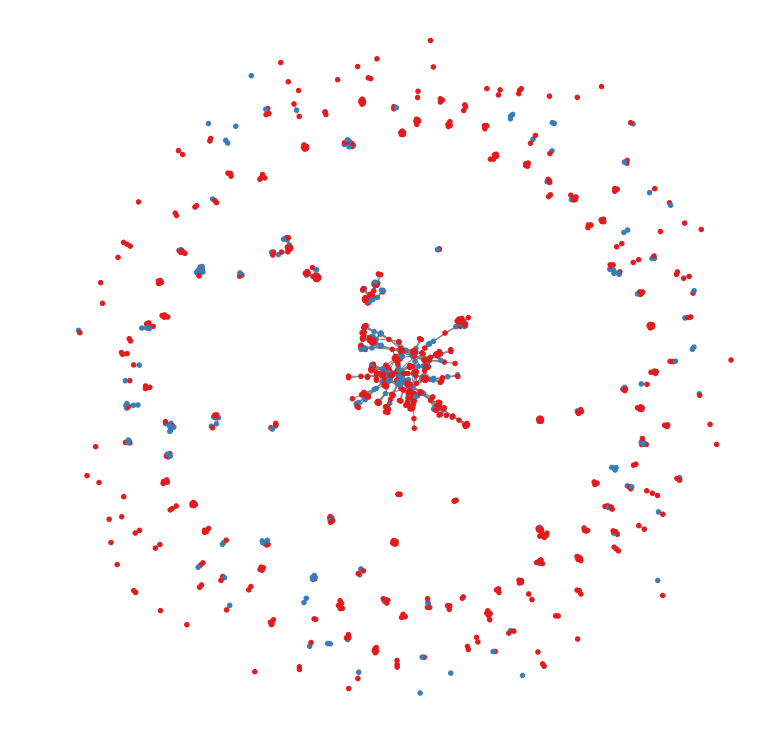

In [80]:
plt.figure(figsize=(10, 10))
nx.draw_spring(graph, cmap=ListedColormap(palette.as_hex()), 
               node_color=nodes.prev.tolist(), width = 1,  edge_color='grey', node_size=[20, 20])

We now analyze these mentors and mentees:

In [81]:
mentoring_connections = self_merge[['long_name_x', 'long_name_y', 'prev_x', 
                                    'prev_y', 'name_x', 'name_y', 'file',
                                   'country_x', 'country_y']]

mentees = mentoring_connections[(mentoring_connections.prev_x != mentoring_connections.prev_y) & 
                      (mentoring_connections.prev_x == 0)]

Number of people that co-authored a paper with somebody who already participated in the conference in previous years:

In [82]:
mentees.long_name_y.drop_duplicates().shape

(226,)

And the institutions they are affiliated with:

In [83]:
mentees[~mentees[['name_y', 'file']].duplicated()].name_y.value_counts().head(10)

Indiana University at Bloomington    14
Stanford University                  13
University of Hong Kong              12
University of Wisconsin - Madison    12
University of Colorado at Boulder    10
Northwestern University               9
Carnegie Mellon University            9
New York University                   8
University of Washington              8
University of Haifa                   7
Name: name_y, dtype: int64

In [84]:
mentees[~mentees[['country_y', 'file']].duplicated()].country_y.value_counts().head(10)

United States     135
Israel             13
Germany            12
Hong Kong          12
Canada              8
United Kingdom      6
Finland             6
Australia           5
Netherlands         5
Japan               5
Name: country_y, dtype: int64

The corresponding mentors:

In [85]:
mentees[~mentees[['long_name_x', 'file']].duplicated()].long_name_x.value_counts().head(10)

Horn, Mike               4
Walkington, Candace A    3
Zohar, Asnat R.          3
Tu, Xintian              3
Davis, Bria              3
Tolar, Erin              3
Penuel, Bill             3
Sabanovic, Selma         3
Dornfeld, Catherine      3
Thompson, Naomi          3
Name: long_name_x, dtype: int64

Looking at lone wolf participants:

In [86]:
def get_loners(mentoring_connections):
    loner_mask = (mentoring_connections.groupby('file').prev_x.sum() + mentoring_connections.groupby('file').prev_y.sum())
    loner_mask = loner_mask[loner_mask == 0].index.tolist()
    return mentoring_connections[mentoring_connections.file.isin(loner_mask)]

In [87]:
lone_wolfs = get_loners(mentoring_connections)

In [88]:
lone_wolfs.long_name_y.drop_duplicates().shape

(344,)

In [89]:
lone_wolfs[~lone_wolfs[['long_name_x', 'file']].duplicated()].long_name_x.value_counts().head()

Palincsar, Annemarie Palincsar    3
Fitzgerald, Miranda S             3
Martin, Lee M                     3
Betser, Sagit                     3
Brooks, Christopher               3
Name: long_name_x, dtype: int64

Here comes in the increase of americans in 2018!

In [90]:
lone_wolfs[~lone_wolfs[['name_x', 'file']].duplicated()].name_x.value_counts().head()

University of Michigan - Ann Arbor    6
University of Illinois at Chicago     5
University of Colorado at Boulder     5
Vanderbilt University                 4
Arizona State University              3
Name: name_x, dtype: int64

In [91]:
lone_wolfs[~lone_wolfs[['country_x', 'file']].duplicated()].country_x.value_counts().head(10)

United States         92
Germany                4
United Kingdom         4
Korea, Republic of     3
Cyprus                 2
Canada                 2
Australia              2
Norway                 2
India                  2
Japan                  1
Name: country_x, dtype: int64

We should also consider the number of papers, not only the number of participants:

In [92]:
mentees.file.unique().shape

(200,)

In [93]:
lone_wolfs.file.unique().shape

(118,)

In [94]:
mentoring_connections.file.unique().shape

(361,)

The number of papers written uniquely by veterans is then:

In [95]:
mentoring_connections.file.unique().shape[0] - (mentees.file.unique().shape[0]+lone_wolfs.file.unique().shape[0])

43

**We take this idea and apply it to the previous years to get a point of comparisoon:**

#### For 2017

In [96]:
previous_participation = set(associations[~associations.issued.isin([2018, 2017])].long_name.tolist())

year_assoc = associations[(associations.Lon.notna()) & (associations.issued == 2017)].copy()

year_assoc['prev'] = 0
year_assoc.loc[year_assoc.long_name.isin(previous_participation),'prev'] = 1

self_merge = pd.merge(year_assoc, year_assoc, on='file')
self_merge = self_merge[(self_merge.long_name_x != self_merge.long_name_y)]

In [97]:
mentoring_connections = self_merge[['long_name_x', 'long_name_y', 'prev_x', 
                                    'prev_y', 'name_x', 'name_y', 'file',
                                   'country_x', 'country_y']]

mentees = mentoring_connections[(mentoring_connections.prev_x != mentoring_connections.prev_y) & 
                      (mentoring_connections.prev_x == 0)]

Number of people that co-authored a paper with somebody who already participated in the conference in previous years:

In [98]:
mentees.long_name_y.drop_duplicates().shape

(97,)

And the institutions they are affiliated with:

In [99]:
mentees[~mentees[['name_y', 'file']].duplicated()].name_y.value_counts().head(10)

Carnegie Mellon University                6
University of Toronto                     4
University of Pennsylvania                4
Pennsylvania State University             4
State University of New York at Albany    4
New York University                       3
University of Wisconsin - Madison         3
Utah State University                     3
Shizuoka University                       3
University of Hong Kong                   3
Name: name_y, dtype: int64

In [100]:
mentees[~mentees[['country_y', 'file']].duplicated()].country_y.value_counts().head(10)

United States    34
Germany           6
Japan             4
Canada            4
Hong Kong         3
Switzerland       3
Romania           2
Singapore         2
Netherlands       1
Australia         1
Name: country_y, dtype: int64

We see that in 2017, the number of new participants is much more consistend with numbers of incomming phd et. comming into the field.

Again, looking at lone wolf participants:

In [101]:
lone_wolfs = lone_wolfs = get_loners(mentoring_connections)
lone_wolfs.long_name_y.drop_duplicates().shape

(121,)

We also see much fewer lone wolf participants:

In [102]:
lone_wolfs[~lone_wolfs[['name_x', 'file']].duplicated()].name_x.value_counts().head()

University of Washington                           3
University College London, University of London    3
George Mason University                            3
University of Wisconsin - Madison                  3
University of Florida                              2
Name: name_x, dtype: int64

In [103]:
lone_wolfs[~lone_wolfs[['country_x', 'file']].duplicated()].country_x.value_counts().head(10)

United States     30
United Kingdom     4
Canada             3
Sweden             2
Cyprus             1
Ireland            1
Israel             1
Germany            1
China              1
Brazil             1
Name: country_x, dtype: int64

We should also consider the number of papers, not only the number of participants:

In [104]:
mentees.file.unique().shape

(48,)

In [105]:
lone_wolfs.file.unique().shape

(36,)

In [106]:
mentoring_connections.file.unique().shape

(101,)

The number of papers written uniquely by veterans is then:

In [107]:
mentoring_connections.file.unique().shape[0] - (mentees.file.unique().shape[0]+lone_wolfs.file.unique().shape[0])

17

#### For 2016

In [108]:
previous_participation = set(associations[~associations.issued.isin([2018, 2017, 2016])].long_name.tolist())

year_assoc = associations[(associations.Lon.notna()) & (associations.issued == 2016)].copy()

year_assoc['prev'] = 0
year_assoc.loc[year_assoc.long_name.isin(previous_participation),'prev'] = 1

self_merge = pd.merge(year_assoc, year_assoc, on='file')
self_merge = self_merge[(self_merge.long_name_x != self_merge.long_name_y)]

In [109]:
mentoring_connections = self_merge[['long_name_x', 'long_name_y', 'prev_x', 
                                    'prev_y', 'name_x', 'name_y', 'file',
                                   'country_x', 'country_y']]

mentees = mentoring_connections[(mentoring_connections.prev_x != mentoring_connections.prev_y) & 
                      (mentoring_connections.prev_x == 0)]

Number of people that co-authored a paper with somebody who already participated in the conference in previous years:

In [110]:
mentees.long_name_y.drop_duplicates().shape

(75,)

And the institutions they are affiliated with:

In [111]:
mentees[~mentees[['name_y', 'file']].duplicated()].name_y.value_counts().head(10)

Ludwig-Maximilians-Universität München    6
University of California, Berkeley        5
University of Wisconsin - Madison         4
EPFL - EPF Lausanne                       4
Universität Augsburg                      3
Indiana University at Bloomington         3
Ruhr-University Bochum                    3
Göteborg University                       2
Carnegie Mellon University                2
University of Minnesota - Twin Cities     2
Name: name_y, dtype: int64

In [112]:
mentees[~mentees[['country_y', 'file']].duplicated()].country_y.value_counts().head(10)

United States    26
Germany          10
Switzerland       4
Canada            4
Hong Kong         2
Israel            2
Sweden            2
Australia         2
Finland           1
Romania           1
Name: country_y, dtype: int64

We see that in 2017, the number of new participants is much more consistend with numbers of incomming phd et. comming into the field.

Again, looking at lone wolf participants:

In [113]:
lone_wolfs = get_loners(mentoring_connections)
lone_wolfs.long_name_y.drop_duplicates().shape

(234,)

We also see much fewer lone wolf participants:

In [114]:
lone_wolfs[~lone_wolfs[['name_x', 'file']].duplicated()].name_x.value_counts().head()

University of Colorado at Boulder     6
Columbia University                   6
University of California, Berkeley    4
Universität Duisburg-Essen            3
East China Normal University          3
Name: name_x, dtype: int64

In [115]:
lone_wolfs[~lone_wolfs[['country_x', 'file']].duplicated()].country_x.value_counts().head(10)

United States     55
United Kingdom     6
Netherlands        4
Israel             4
Germany            4
Finland            3
China              3
Canada             3
Singapore          2
Hong Kong          2
Name: country_x, dtype: int64

We should also consider the number of papers, not only the number of participants:

In [116]:
mentees.file.unique().shape

(45,)

In [117]:
lone_wolfs.file.unique().shape

(75,)

In [118]:
mentoring_connections.file.unique().shape

(130,)

The number of papers written uniquely by veterans is then:

In [119]:
mentoring_connections.file.unique().shape[0] - (mentees.file.unique().shape[0]+lone_wolfs.file.unique().shape[0])

10